# Exploratory Data Analysis: Educational Process Mining (EPM) Dataset

This notebook provides a comprehensive exploratory data analysis of the Educational Process Mining dataset, which contains sequential event logs of student interactions during digital electronics laboratory sessions.

## Dataset Overview
The dataset contains information about 115 first-year undergraduate Engineering students from the University of Genoa:
- **6 laboratory sessions** with 4-6 exercises per session
- **Sequential event logs** with 13 features per activity
- **Time-series data** of student interactions with learning tools
- **Final and intermediate grades** for performance analysis

### Key Features:
- **Temporal**: session, start_time, end_time, idle_time
- **Activity**: exercise, activity type (Study, Deeds, TextEditor, etc.)
- **Interaction**: mouse_wheel, mouse_click_left/right, mouse_movement, keystroke
- **Performance**: final exam grades, intermediate session grades

### Learning Tools:
- **Deeds**: Digital Electronics Education and Design Suite (circuit simulator)
- **TextEditor**: Word/Office for writing solutions
- **FSM**: Finite State Machine Simulator
- **Aulaweb**: Learning Management System (Moodle-based)
- **Study Materials**: Course materials provided by instructor


In [1]:
# Install required packages
!pip install -q pandas numpy matplotlib seaborn openpyxl



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path
from datetime import datetime
import glob
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 7)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")


Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 1.26.4
Matplotlib version: 3.10.1
Seaborn version: 0.13.2


## 1. Data Loading and Initial Inspection


In [3]:
# Find dataset directory
base_paths = [
    '../../datasets/epm-dataset/',  # From pretests/charaka/
    'datasets/epm-dataset/',        # From project root
    '../datasets/epm-dataset/'      # From pretests/
]

dataset_dir = None
for path in base_paths:
    if os.path.exists(path):
        dataset_dir = path
        break

if dataset_dir is None:
    raise FileNotFoundError(f"Could not find dataset directory. Tried: {base_paths}")

print(f"Dataset directory: {os.path.abspath(dataset_dir)}")

# Define feature names
feature_names = [
    'session', 'student_Id', 'exercise', 'activity', 'start_time', 'end_time',
    'idle_time', 'mouse_wheel', 'mouse_wheel_click', 'mouse_click_left',
    'mouse_click_right', 'mouse_movement', 'keystroke'
]

print(f"\nFeatures: {feature_names}")


Dataset directory: /Users/charaka/Desktop/Projects/uom-student-performance-analytics/datasets/epm-dataset

Features: ['session', 'student_Id', 'exercise', 'activity', 'start_time', 'end_time', 'idle_time', 'mouse_wheel', 'mouse_wheel_click', 'mouse_click_left', 'mouse_click_right', 'mouse_movement', 'keystroke']


In [4]:
# Load all process files from all sessions
def load_process_files(dataset_dir):
    """Load all process files from Session 1-6 folders"""
    all_data = []
    processes_dir = os.path.join(dataset_dir, 'Data', 'Processes')
    
    for session_num in range(1, 7):
        session_dir = os.path.join(processes_dir, f'Session {session_num}')
        if not os.path.exists(session_dir):
            print(f"Warning: {session_dir} not found")
            continue
            
        # Get all files in session directory (student IDs)
        student_files = [f for f in os.listdir(session_dir) 
                        if os.path.isfile(os.path.join(session_dir, f))]
        
        print(f"Session {session_num}: {len(student_files)} student files")
        
        for student_file in student_files:
            student_id = int(student_file)
            file_path = os.path.join(session_dir, student_file)
            
            try:
                # Read CSV without header
                df_temp = pd.read_csv(file_path, header=None, names=feature_names)
                all_data.append(df_temp)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    if all_data:
        df = pd.concat(all_data, ignore_index=True)
        return df
    else:
        return pd.DataFrame()

print("Loading process files...")
df = load_process_files(dataset_dir)
print(f"\nTotal records loaded: {len(df):,}")
print(f"Shape: {df.shape}")


Loading process files...
Session 1: 77 student files
Session 2: 82 student files
Session 3: 87 student files
Session 4: 99 student files
Session 5: 91 student files
Session 6: 84 student files

Total records loaded: 230,318
Shape: (230318, 13)


In [5]:
# Display basic information
print("Dataset Info:")
print("=" * 50)
print(df.info())
print("\n" + "=" * 50)
print("\nFirst few rows:")
print(df.head(10))
print("\n" + "=" * 50)
print("\nBasic Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230318 entries, 0 to 230317
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   session            230318 non-null  int64 
 1   student_Id         230318 non-null  int64 
 2   exercise           230318 non-null  object
 3   activity           230318 non-null  object
 4   start_time         230318 non-null  object
 5   end_time           230318 non-null  object
 6   idle_time          230318 non-null  int64 
 7   mouse_wheel        230318 non-null  int64 
 8   mouse_wheel_click  230318 non-null  int64 
 9   mouse_click_left   230318 non-null  int64 
 10  mouse_click_right  230318 non-null  int64 
 11  mouse_movement     230318 non-null  int64 
 12  keystroke          230318 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 22.8+ MB
None


First few rows:
   session  student_Id exercise       activity           start_time  \
0        1

In [6]:
# Parse timestamps
df['start_time'] = pd.to_datetime(df['start_time'], format='%d.%m.%Y %H:%M:%S', errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], format='%d.%m.%Y %H:%M:%S', errors='coerce')

# Calculate activity duration in seconds
df['duration_seconds'] = (df['end_time'] - df['start_time']).dt.total_seconds()
df['duration_minutes'] = df['duration_seconds'] / 60

# Convert idle_time from milliseconds to seconds
df['idle_time_seconds'] = df['idle_time'] / 1000

# Check for missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Rows with missing timestamps: {df[df['start_time'].isna() | df['end_time'].isna()].shape[0]}")


Missing values:
session                   0
student_Id                0
exercise                  0
activity                  0
start_time           196024
end_time             196024
idle_time                 0
mouse_wheel               0
mouse_wheel_click         0
mouse_click_left          0
mouse_click_right         0
mouse_movement            0
keystroke                 0
duration_seconds     196024
duration_minutes     196024
idle_time_seconds         0
dtype: int64

Total missing values: 784096
Rows with missing timestamps: 196024


## 2. Dataset Overview & Summary Statistics


In [7]:
# Basic dataset statistics
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Total records: {len(df):,}")
print(f"Unique students: {df['student_Id'].nunique()}")
print(f"Sessions: {sorted(df['session'].unique())}")
print(f"Date range: {df['start_time'].min()} to {df['start_time'].max()}")
print(f"Total activities: {df['activity'].nunique()}")
print(f"Unique exercises: {df['exercise'].nunique()}")

print("\n" + "=" * 60)
print("STUDENTS PER SESSION")
print("=" * 60)
students_per_session = df.groupby('session')['student_Id'].nunique()
print(students_per_session)

print("\n" + "=" * 60)
print("RECORDS PER SESSION")
print("=" * 60)
records_per_session = df.groupby('session').size()
print(records_per_session)


DATASET OVERVIEW
Total records: 230,318
Unique students: 115
Sessions: [1, 2, 3, 4, 5, 6]
Date range: 2014-10-02 09:24:19 to 2014-10-02 21:09:09
Total activities: 99
Unique exercises: 30

STUDENTS PER SESSION
session
1    77
2    82
3    87
4    99
5    91
6    84
Name: student_Id, dtype: int64

RECORDS PER SESSION
session
1    34294
2    39549
3    29127
4    39709
5    34469
6    53170
dtype: int64


In [8]:
# Load attendance logs
logs_path = os.path.join(dataset_dir, 'Data', 'logs.txt')
logs_df = pd.read_csv(logs_path, sep='\t')
print("Attendance Logs:")
print(logs_df.head(10))
print(f"\nTotal students in logs: {len(logs_df)}")
print(f"\nAttendance summary:")
for col in logs_df.columns[1:]:
    print(f"{col}: {logs_df[col].sum()} students")


Attendance Logs:
   Student Id  Session 1  Session 2  Session 3  Session 4  Session 5  \
0           1          1          1          0          1          1   
1           2          1          1          1          1          1   
2           3          0          1          1          1          1   
3           4          1          1          1          1          1   
4           5          1          1          1          1          1   
5           6          0          1          1          1          1   
6           7          1          1          1          1          1   
7           8          0          1          1          1          1   
8           9          1          0          1          1          1   
9          10          1          1          1          1          1   

   Session 6  
0          1  
1          1  
2          0  
3          1  
4          1  
5          1  
6          1  
7          0  
8          1  
9          1  

Total students in logs: 

## 3. Activity Analysis


In [9]:
# Activity frequency analysis
activity_counts = df['activity'].value_counts()
print("Activity Frequency:")
print("=" * 60)
print(activity_counts)

# Activity percentage
activity_pct = df['activity'].value_counts(normalize=True) * 100
print("\nActivity Percentage:")
print("=" * 60)
print(activity_pct.round(2))


Activity Frequency:
activity
Other                33602
Blank                24303
Diagram              20815
Properties           19677
Aulaweb               8261
FSM_Es_6_3            7709
FSM_Es_6_2            5505
TextEditor            4817
Deeds_Es_4_5          3994
FSM_Es_6_1            3938
FSM_Related           3295
TextEditor_Es_3_2     3010
Deeds_Es_2_2          2754
TextEditor_Es_5_4     2622
Deeds_Es_5_4          2551
Deeds_Es_3_2          2458
TextEditor_Es_3_1     2150
TextEditor_Es_2_1     2137
Deeds_Es_1_2          2108
Deeds_Es_1_1          2066
TextEditor_Es_2_2     2013
Deeds_Es_5_1          2008
TextEditor_Es_2_4     1858
TextEditor_Es_5_1     1823
Deeds_Es_5_3          1812
TextEditor_Es_4_5     1763
Deeds_Es_2_4          1744
Study_Es_6_3          1705
Deeds_Es_2_1          1686
TextEditor_Es_5_3     1647
Deeds_Es_3_1          1628
Deeds_Es_1_3          1606
Study_Es_5_4          1593
TextEditor_Es_1_2     1558
TextEditor_Es_1_1     1487
TextEditor_Es_4_1     1400

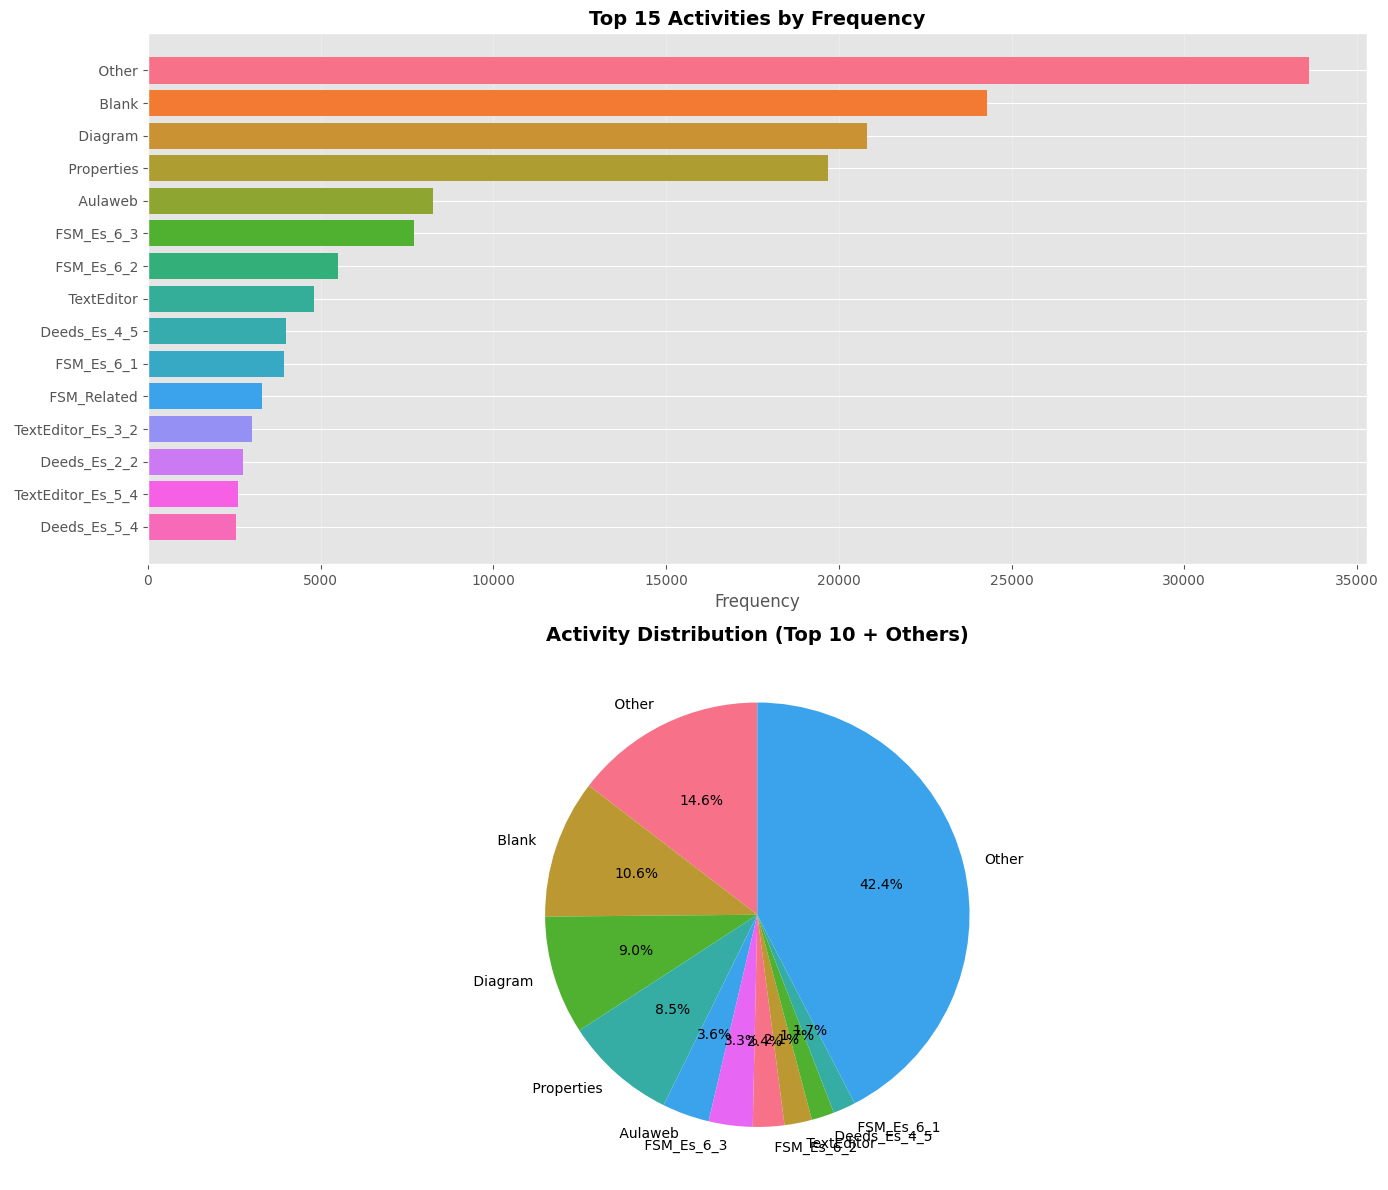

In [10]:
# Visualize activity distribution
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Top activities bar chart
top_activities = activity_counts.head(15)
axes[0].barh(range(len(top_activities)), top_activities.values, color=sns.color_palette("husl", len(top_activities)))
axes[0].set_yticks(range(len(top_activities)))
axes[0].set_yticklabels(top_activities.index)
axes[0].set_xlabel('Frequency', fontsize=12)
axes[0].set_title('Top 15 Activities by Frequency', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Activity pie chart (top 10)
top_10_activities = activity_counts.head(10)
other_count = activity_counts.tail(len(activity_counts) - 10).sum()
if other_count > 0:
    pie_data = list(top_10_activities.values) + [other_count]
    pie_labels = list(top_10_activities.index) + ['Other']
else:
    pie_data = top_10_activities.values
    pie_labels = top_10_activities.index

axes[1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Activity Distribution (Top 10 + Others)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [11]:
# Categorize activities
def categorize_activity(activity):
    """Categorize activities into main groups"""
    activity_str = str(activity)
    if 'Study_Es' in activity_str:
        return 'Study'
    elif 'Deeds_Es' in activity_str or activity_str == 'Deeds':
        return 'Deeds_Simulator'
    elif 'TextEditor_Es' in activity_str or activity_str == 'TextEditor':
        return 'TextEditor'
    elif 'FSM' in activity_str:
        return 'FSM_Simulator'
    elif activity_str == 'Aulaweb':
        return 'LMS'
    elif activity_str == 'Study_Materials':
        return 'Study_Materials'
    elif activity_str in ['Diagram', 'Properties']:
        return 'Tools'
    elif activity_str == 'Other':
        return 'Other'
    elif activity_str == 'Blank':
        return 'Blank'
    else:
        return 'Other'

df['activity_category'] = df['activity'].apply(categorize_activity)

# Activity category analysis
category_counts = df['activity_category'].value_counts()
print("Activity Category Distribution:")
print("=" * 60)
print(category_counts)
print("\nPercentage:")
print((category_counts / len(df) * 100).round(2))


Activity Category Distribution:
activity_category
Other              112983
TextEditor          37614
Deeds_Simulator     37306
Study               21844
FSM_Simulator       20571
Name: count, dtype: int64

Percentage:
activity_category
Other              49.06
TextEditor         16.33
Deeds_Simulator    16.20
Study               9.48
FSM_Simulator       8.93
Name: count, dtype: float64


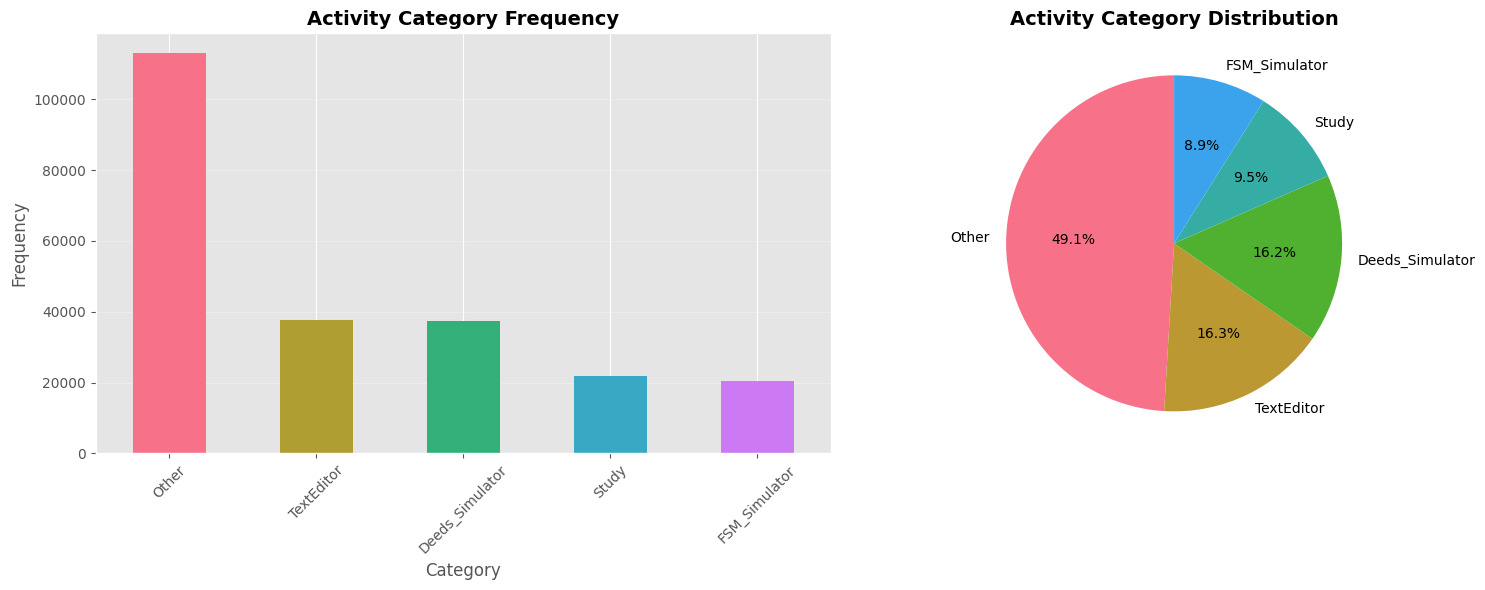

In [12]:
# Visualize activity categories
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
category_counts.plot(kind='bar', ax=axes[0], color=sns.color_palette("husl", len(category_counts)))
axes[0].set_title('Activity Category Frequency', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Category', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
category_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Activity Category Distribution', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


## 4. Temporal Analysis


In [13]:
# Session duration analysis
session_durations = df.groupby(['session', 'student_Id']).agg({
    'start_time': 'min',
    'end_time': 'max'
}).reset_index()
session_durations['session_duration_hours'] = (
    session_durations['end_time'] - session_durations['start_time']
).dt.total_seconds() / 3600

print("Session Duration Statistics (hours):")
print("=" * 60)
print(session_durations.groupby('session')['session_duration_hours'].describe())

# Overall statistics
print("\nOverall Session Duration:")
print(f"Mean: {session_durations['session_duration_hours'].mean():.2f} hours")
print(f"Median: {session_durations['session_duration_hours'].median():.2f} hours")
print(f"Min: {session_durations['session_duration_hours'].min():.2f} hours")
print(f"Max: {session_durations['session_duration_hours'].max():.2f} hours")


Session Duration Statistics (hours):
         count      mean       std       min       25%       50%       75%  \
session                                                                      
1         77.0  1.594408  0.443209  0.446944  1.343889  1.578889  1.783889   
2          0.0       NaN       NaN       NaN       NaN       NaN       NaN   
3          0.0       NaN       NaN       NaN       NaN       NaN       NaN   
4          0.0       NaN       NaN       NaN       NaN       NaN       NaN   
5          0.0       NaN       NaN       NaN       NaN       NaN       NaN   
6          0.0       NaN       NaN       NaN       NaN       NaN       NaN   

              max  
session            
1        4.338611  
2             NaN  
3             NaN  
4             NaN  
5             NaN  
6             NaN  

Overall Session Duration:
Mean: 1.59 hours
Median: 1.58 hours
Min: 0.45 hours
Max: 4.34 hours


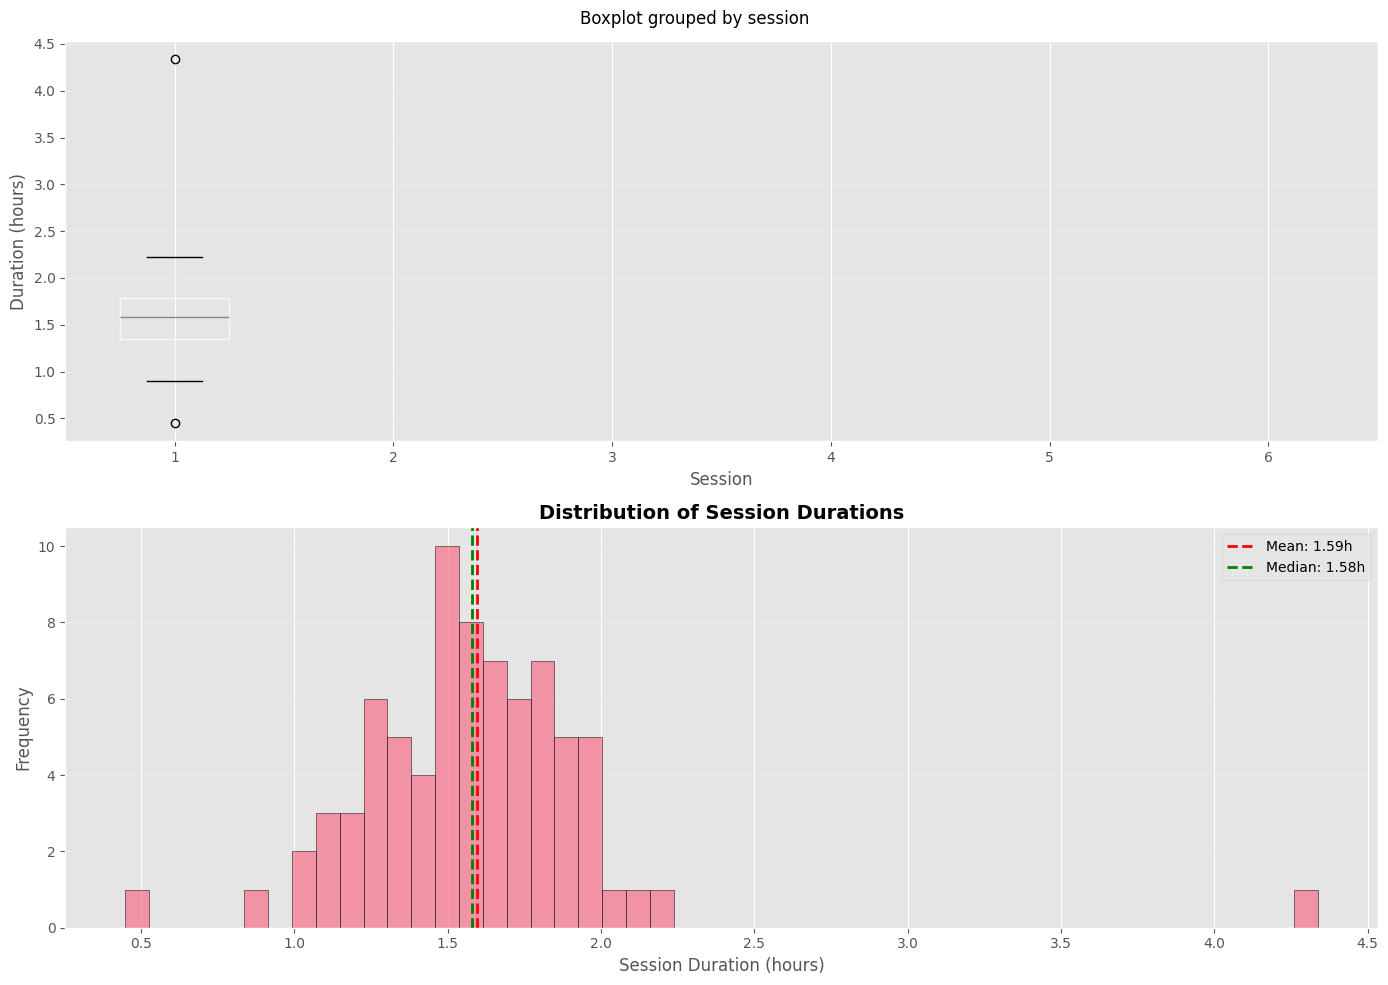

In [14]:
# Visualize session durations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Box plot by session
session_durations.boxplot(column='session_duration_hours', by='session', ax=axes[0])
axes[0].set_title('Session Duration Distribution by Session', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Session', fontsize=12)
axes[0].set_ylabel('Duration (hours)', fontsize=12)
axes[0].set_title('')  # Remove default title
axes[0].grid(axis='y', alpha=0.3)

# Histogram
axes[1].hist(session_durations['session_duration_hours'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(session_durations['session_duration_hours'].mean(), 
                color='red', linestyle='--', linewidth=2, label=f'Mean: {session_durations["session_duration_hours"].mean():.2f}h')
axes[1].axvline(session_durations['session_duration_hours'].median(), 
                color='green', linestyle='--', linewidth=2, label=f'Median: {session_durations["session_duration_hours"].median():.2f}h')
axes[1].set_xlabel('Session Duration (hours)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Session Durations', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [15]:
# Activity duration analysis
activity_durations = df[df['duration_minutes'] > 0].copy()  # Filter out invalid durations

print("Activity Duration Statistics (minutes):")
print("=" * 60)
print(activity_durations.groupby('activity_category')['duration_minutes'].describe())

# Top activities by average duration
avg_duration_by_activity = activity_durations.groupby('activity')['duration_minutes'].mean().sort_values(ascending=False)
print("\nTop 10 Activities by Average Duration:")
print(avg_duration_by_activity.head(10))


Activity Duration Statistics (minutes):
                     count      mean       std       min       25%       50%  \
activity_category                                                              
Deeds_Simulator     6233.0  0.438435  1.072437  0.016667  0.033333  0.100000   
Other              12527.0  0.184352  0.539850  0.016667  0.016667  0.050000   
Study               3090.0  0.176073  0.311869  0.016667  0.033333  0.083333   
TextEditor          4210.0  0.253702  0.418990  0.016667  0.050000  0.116667   

                        75%        max  
activity_category                       
Deeds_Simulator    0.300000  14.933333  
Other              0.133333  22.033333  
Study              0.183333   5.816667  
TextEditor         0.283333   7.450000  

Top 10 Activities by Average Duration:
activity
Diagram              0.564750
Deeds_Es_1_1         0.552746
Deeds_Es_1_4         0.549577
Study_Materials      0.533333
Deeds_Es_1_2         0.410570
Deeds_Es             0.382245
Text

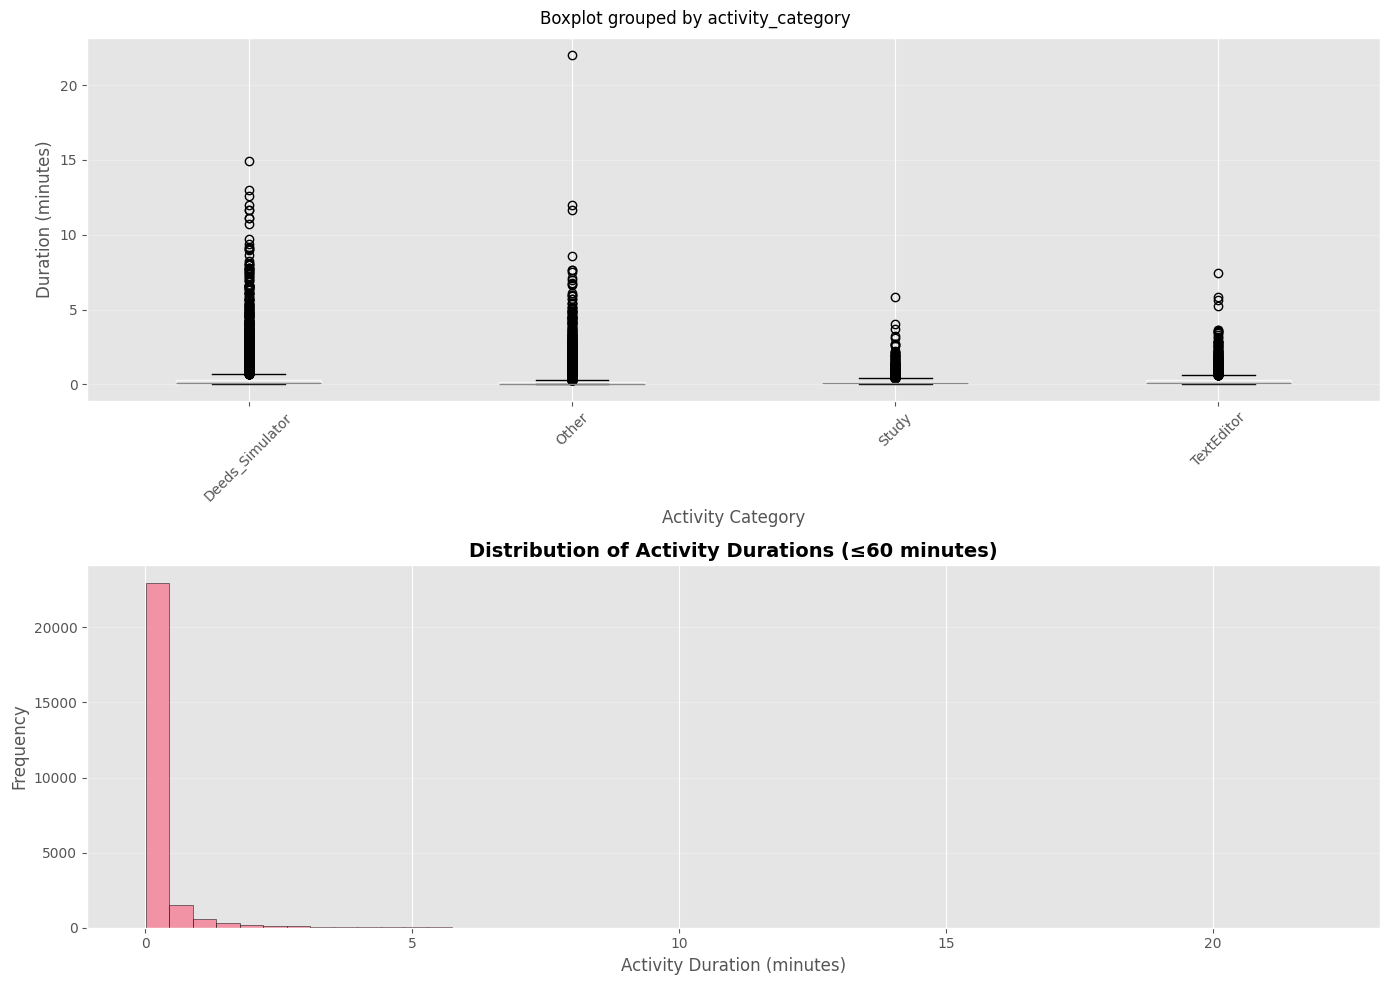

In [16]:
# Visualize activity durations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Box plot by activity category
activity_durations.boxplot(column='duration_minutes', by='activity_category', ax=axes[0])
axes[0].set_title('Activity Duration by Category', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Activity Category', fontsize=12)
axes[0].set_ylabel('Duration (minutes)', fontsize=12)
axes[0].set_title('')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Filter extreme outliers for better visualization
duration_filtered = activity_durations[activity_durations['duration_minutes'] <= 60]
axes[1].hist(duration_filtered['duration_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Activity Duration (minutes)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Activity Durations (≤60 minutes)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [17]:
# Idle time analysis
print("Idle Time Statistics:")
print("=" * 60)
print(f"Total idle time: {df['idle_time_seconds'].sum() / 3600:.2f} hours")
print(f"Mean idle time per activity: {df['idle_time_seconds'].mean():.2f} seconds")
print(f"Median idle time per activity: {df['idle_time_seconds'].median():.2f} seconds")
print(f"Max idle time: {df['idle_time_seconds'].max() / 60:.2f} minutes")

# Idle time by activity category
idle_by_category = df.groupby('activity_category')['idle_time_seconds'].agg(['mean', 'median', 'sum'])
print("\nIdle Time by Activity Category:")
print(idle_by_category)


Idle Time Statistics:
Total idle time: -118222355.30 hours
Mean idle time per activity: -1847881.97 seconds
Median idle time per activity: 0.08 seconds
Max idle time: 120745.60 minutes

Idle Time by Activity Category:
                           mean  median           sum
activity_category                                    
Deeds_Simulator   -1.390706e+06  0.2520 -5.188169e+10
FSM_Simulator      1.073681e+03  0.4700  2.208670e+07
Other             -3.510950e+04  0.0150 -3.966777e+09
Study             -3.775672e+05  0.7320 -8.247577e+09
TextEditor        -9.611488e+06  2.1255 -3.615265e+11


Activity by Hour of Day:
hour
9.0       405
10.0      496
11.0     6592
12.0    20506
13.0     5275
14.0      440
19.0       99
20.0      378
21.0      103
dtype: int64


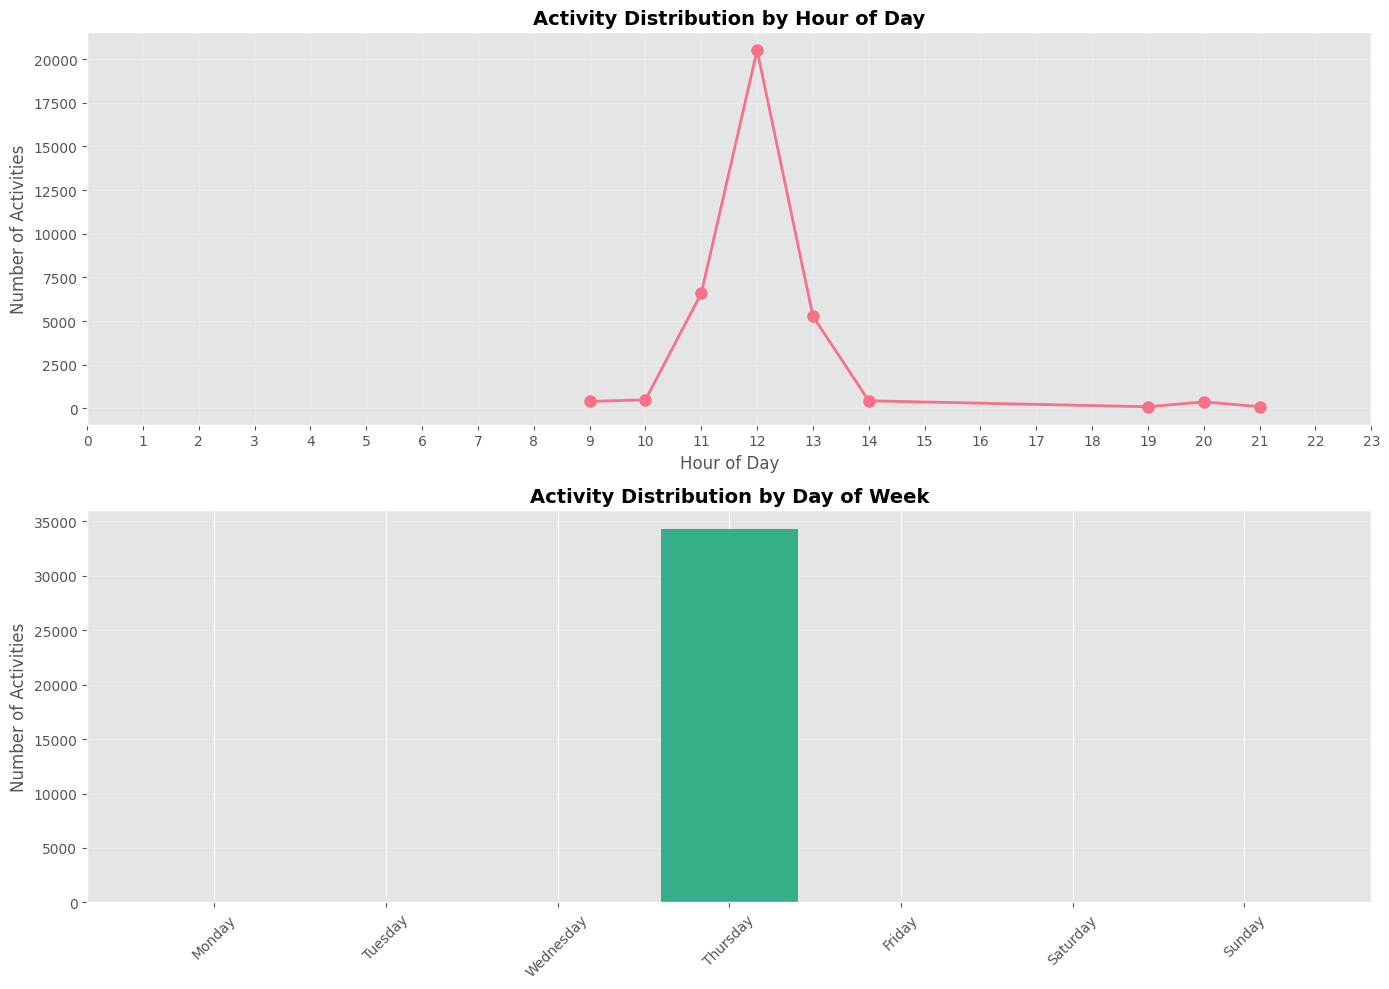

In [18]:
# Time-of-day patterns
df['hour'] = df['start_time'].dt.hour
df['day_of_week'] = df['start_time'].dt.day_name()

# Activity by hour
hourly_activity = df.groupby('hour').size()
print("Activity by Hour of Day:")
print(hourly_activity)

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Hourly activity
axes[0].plot(hourly_activity.index, hourly_activity.values, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Number of Activities', fontsize=12)
axes[0].set_title('Activity Distribution by Hour of Day', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(range(24))

# Day of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_activity = df.groupby('day_of_week').size().reindex(day_order, fill_value=0)
axes[1].bar(range(len(daily_activity)), daily_activity.values, color=sns.color_palette("husl", len(daily_activity)))
axes[1].set_xticks(range(len(daily_activity)))
axes[1].set_xticklabels(daily_activity.index, rotation=45)
axes[1].set_ylabel('Number of Activities', fontsize=12)
axes[1].set_title('Activity Distribution by Day of Week', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Interaction Metrics Analysis


In [19]:
# Mouse interaction analysis
print("Mouse Interaction Statistics:")
print("=" * 60)
print(f"Total mouse movements: {df['mouse_movement'].sum():,}")
print(f"Total left clicks: {df['mouse_click_left'].sum():,}")
print(f"Total right clicks: {df['mouse_click_right'].sum():,}")
print(f"Total wheel clicks: {df['mouse_wheel_click'].sum():,}")
print(f"Total wheel movement: {df['mouse_wheel'].sum():,}")

# Keystroke analysis
print(f"\nKeystroke Statistics:")
print(f"Total keystrokes: {df['keystroke'].sum():,}")
print(f"Mean keystrokes per activity: {df['keystroke'].mean():.2f}")
print(f"Median keystrokes per activity: {df['keystroke'].median():.2f}")

# Interaction by activity category
interaction_by_category = df.groupby('activity_category').agg({
    'mouse_movement': 'sum',
    'mouse_click_left': 'sum',
    'mouse_click_right': 'sum',
    'keystroke': 'sum'
})
print("\nInteraction Metrics by Activity Category:")
print(interaction_by_category)


Mouse Interaction Statistics:
Total mouse movements: 95,474,355
Total left clicks: 1,628,066
Total right clicks: 77,412
Total wheel clicks: 1,254
Total wheel movement: 631,959

Keystroke Statistics:
Total keystrokes: 1,446,359
Mean keystrokes per activity: 6.28
Median keystrokes per activity: 0.00

Interaction Metrics by Activity Category:
                   mouse_movement  mouse_click_left  mouse_click_right  \
activity_category                                                        
Deeds_Simulator          24347852            476608              56416   
FSM_Simulator            16218595            270775               2715   
Other                    24368259            449270              12802   
Study                     7352806             74634                357   
TextEditor               23186843            356779               5122   

                   keystroke  
activity_category             
Deeds_Simulator        68367  
FSM_Simulator          49385  
Other          

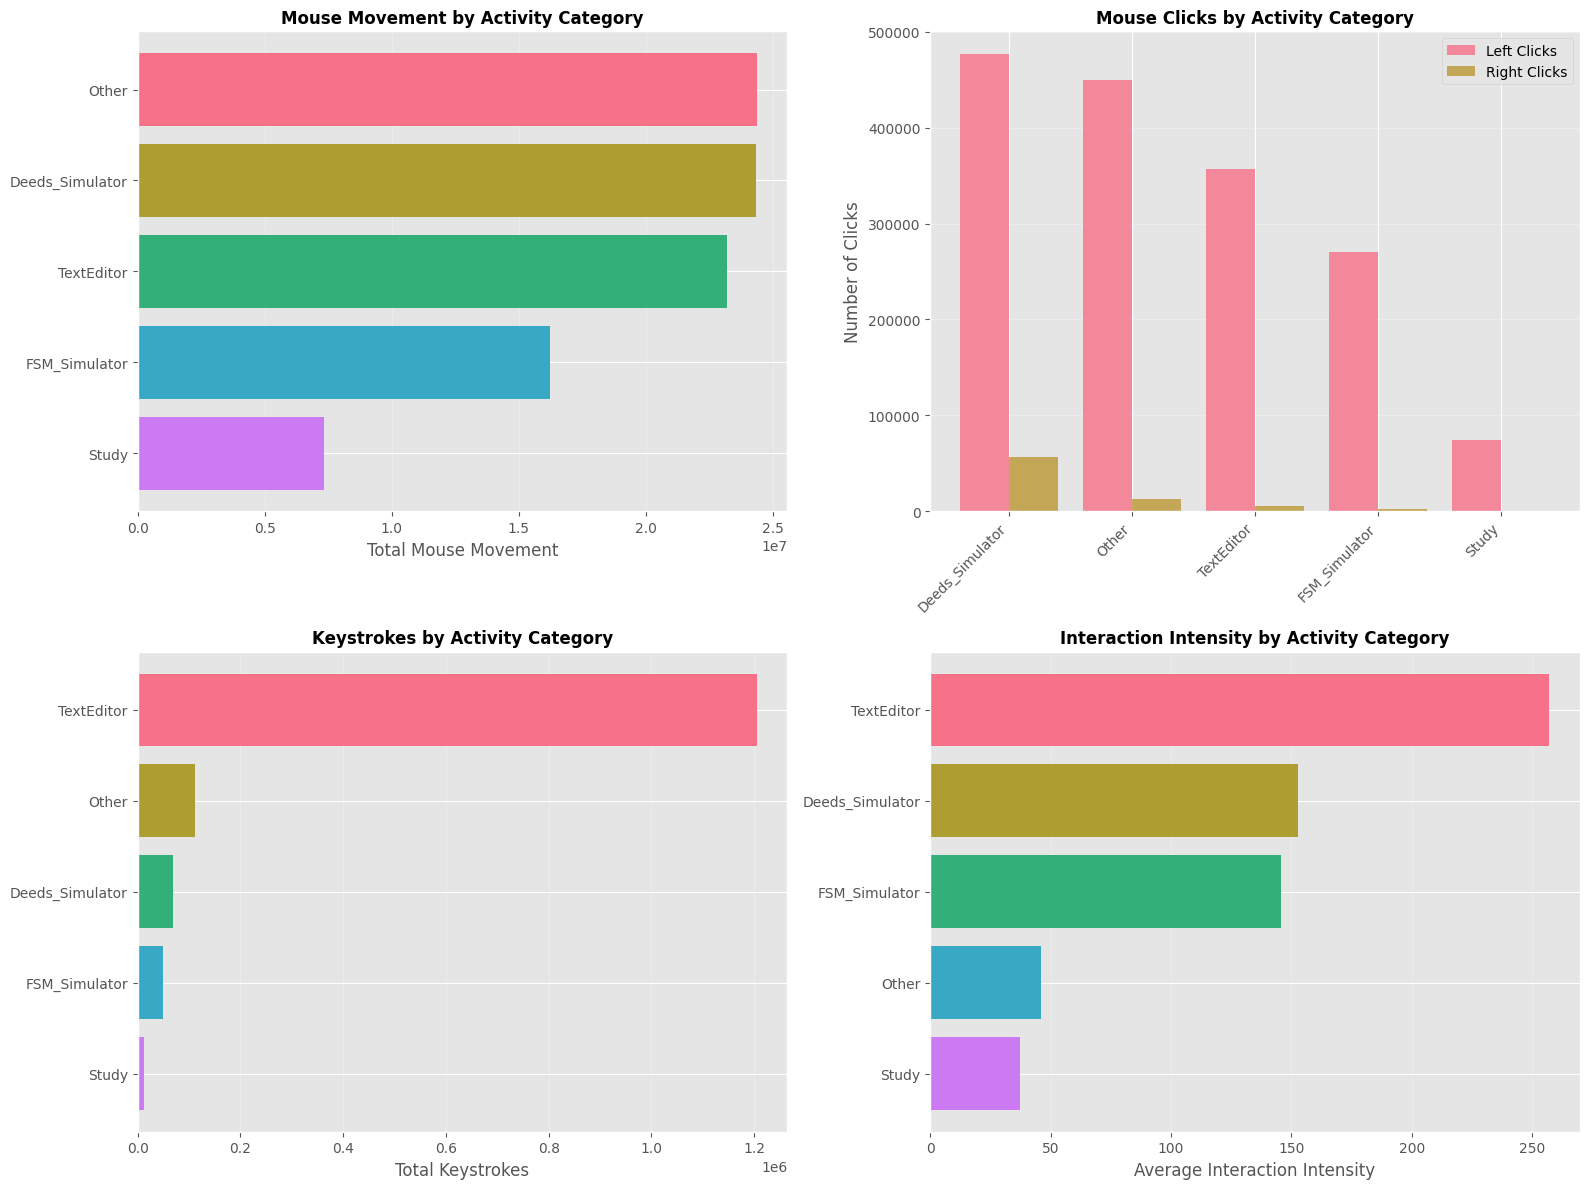

In [20]:
# Visualize interaction metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Mouse movement
mouse_by_category = df.groupby('activity_category')['mouse_movement'].sum().sort_values(ascending=False)
axes[0, 0].barh(range(len(mouse_by_category)), mouse_by_category.values, color=sns.color_palette("husl", len(mouse_by_category)))
axes[0, 0].set_yticks(range(len(mouse_by_category)))
axes[0, 0].set_yticklabels(mouse_by_category.index)
axes[0, 0].set_xlabel('Total Mouse Movement', fontsize=12)
axes[0, 0].set_title('Mouse Movement by Activity Category', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Mouse clicks
clicks_by_category = df.groupby('activity_category').agg({
    'mouse_click_left': 'sum',
    'mouse_click_right': 'sum'
}).sort_values('mouse_click_left', ascending=False)
x_pos = np.arange(len(clicks_by_category))
axes[0, 1].bar(x_pos - 0.2, clicks_by_category['mouse_click_left'], width=0.4, label='Left Clicks', alpha=0.8)
axes[0, 1].bar(x_pos + 0.2, clicks_by_category['mouse_click_right'], width=0.4, label='Right Clicks', alpha=0.8)
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(clicks_by_category.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Number of Clicks', fontsize=12)
axes[0, 1].set_title('Mouse Clicks by Activity Category', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Keystrokes
keystroke_by_category = df.groupby('activity_category')['keystroke'].sum().sort_values(ascending=False)
axes[1, 0].barh(range(len(keystroke_by_category)), keystroke_by_category.values, color=sns.color_palette("husl", len(keystroke_by_category)))
axes[1, 0].set_yticks(range(len(keystroke_by_category)))
axes[1, 0].set_yticklabels(keystroke_by_category.index)
axes[1, 0].set_xlabel('Total Keystrokes', fontsize=12)
axes[1, 0].set_title('Keystrokes by Activity Category', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Interaction intensity (composite score)
df['interaction_intensity'] = (
    df['mouse_movement'] / 1000 +  # Normalize
    df['mouse_click_left'] * 10 +
    df['mouse_click_right'] * 10 +
    df['keystroke'] * 5
)
intensity_by_category = df.groupby('activity_category')['interaction_intensity'].mean().sort_values(ascending=False)
axes[1, 1].barh(range(len(intensity_by_category)), intensity_by_category.values, color=sns.color_palette("husl", len(intensity_by_category)))
axes[1, 1].set_yticks(range(len(intensity_by_category)))
axes[1, 1].set_yticklabels(intensity_by_category.index)
axes[1, 1].set_xlabel('Average Interaction Intensity', fontsize=12)
axes[1, 1].set_title('Interaction Intensity by Activity Category', fontsize=12, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Exercise Analysis


In [21]:
# Exercise analysis
print("Exercise Statistics:")
print("=" * 60)
exercise_counts = df['exercise'].value_counts()
print(f"Total unique exercises: {df['exercise'].nunique()}")
print(f"\nTop 20 exercises by frequency:")
print(exercise_counts.head(20))

# Exercises per session
exercises_per_session = df.groupby('session')['exercise'].nunique()
print("\nExercises per Session:")
print(exercises_per_session)


Exercise Statistics:
Total unique exercises: 30

Top 20 exercises by frequency:
exercise
Es_4_5    22351
Es_6_3    19549
Es_6_2    16128
Es_6_1    13617
Es_5_4    12376
Es_1_1    11531
Es_2_2    10527
Es_3_2    10199
Es_1_2     9795
Es_5_1     9161
Es_2_1     7960
Es_3_1     7886
Es_2_4     7708
Es_5_3     7256
Es_1_3     6878
Es_2_3     6169
Es_4_1     5789
Es_1_4     5575
Es_3_4     5344
Es_5_2     5234
Name: count, dtype: int64

Exercises per Session:
session
1     5
2    10
3    15
4    11
5    12
6    12
Name: exercise, dtype: int64


In [22]:
# Time spent per exercise
exercise_time = df.groupby('exercise').agg({
    'duration_minutes': 'sum',
    'student_Id': 'nunique',
    'activity': 'count'
}).sort_values('duration_minutes', ascending=False)
exercise_time.columns = ['total_time_minutes', 'unique_students', 'total_activities']
exercise_time['avg_time_per_student'] = exercise_time['total_time_minutes'] / exercise_time['unique_students']

print("Exercise Engagement (Top 15):")
print("=" * 60)
print(exercise_time.head(15))


Exercise Engagement (Top 15):
          total_time_minutes  unique_students  total_activities  \
exercise                                                          
Es_1_1           2704.900000               78             11531   
Es_1_2           1764.700000               77              9795   
Es_1_4           1091.550000               76              5575   
Es_1_3            922.983333               77              6878   
Es                170.166667              115              2675   
Es_5_4              0.000000               91             12376   
Es_4_5              0.000000               99             22351   
Es_5_1              0.000000               90              9161   
Es_5_2              0.000000               90              5234   
Es_5_3              0.000000               90              7256   
Es_6_2              0.000000               84             16128   
Es_6_1              0.000000               84             13617   
Es_4_3              0.000000    

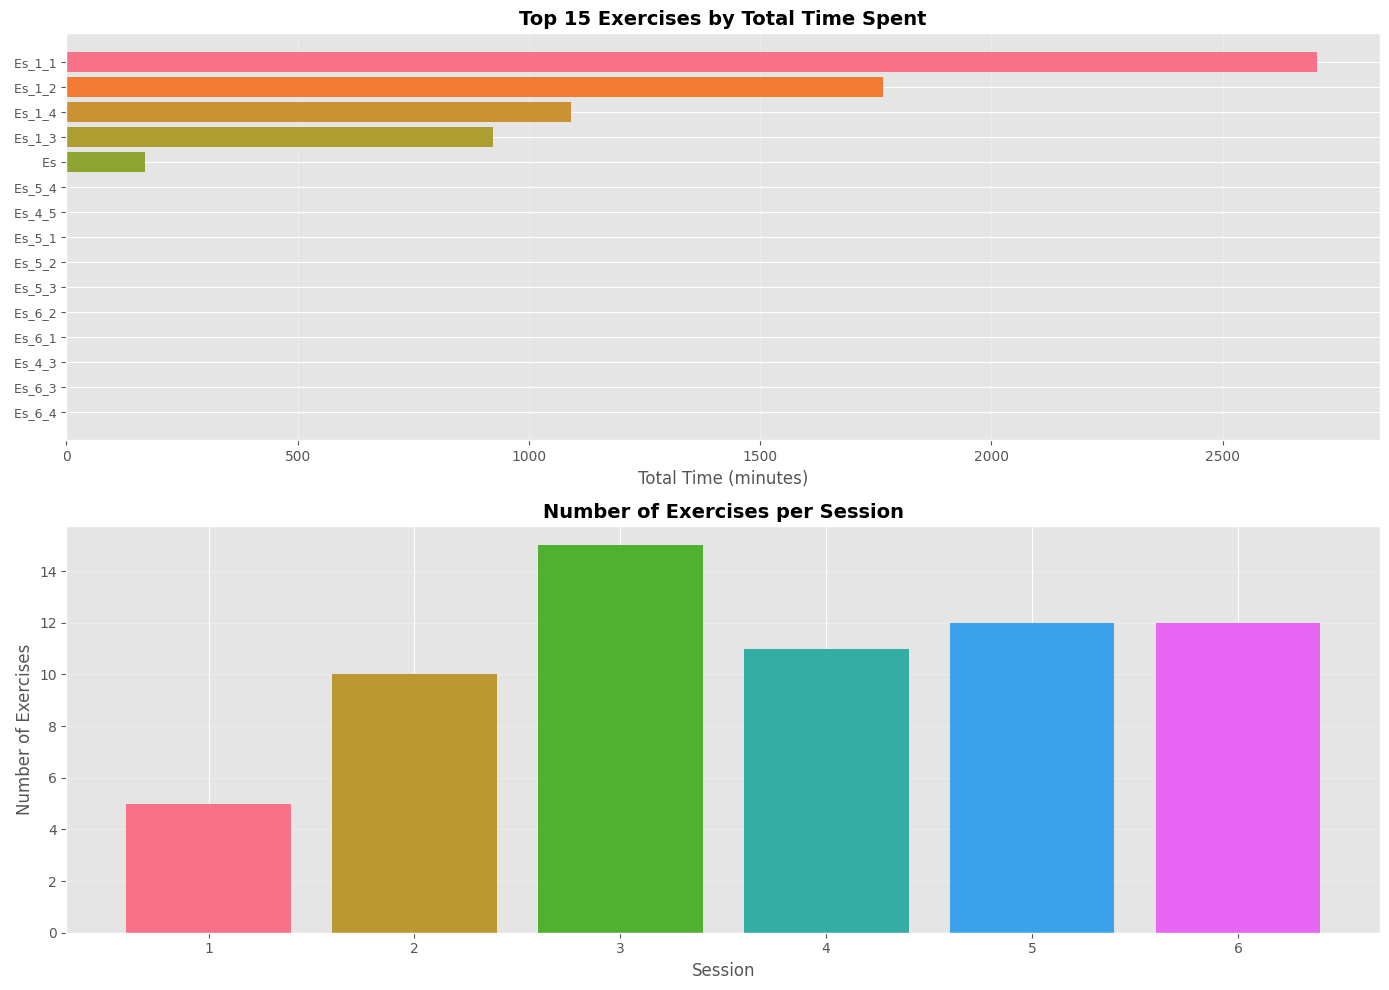

In [23]:
# Visualize exercise engagement
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top exercises by total time
top_exercises = exercise_time.head(15)
axes[0].barh(range(len(top_exercises)), top_exercises['total_time_minutes'].values, 
             color=sns.color_palette("husl", len(top_exercises)))
axes[0].set_yticks(range(len(top_exercises)))
axes[0].set_yticklabels(top_exercises.index, fontsize=9)
axes[0].set_xlabel('Total Time (minutes)', fontsize=12)
axes[0].set_title('Top 15 Exercises by Total Time Spent', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Exercises per session
axes[1].bar(exercises_per_session.index, exercises_per_session.values, 
            color=sns.color_palette("husl", len(exercises_per_session)))
axes[1].set_xlabel('Session', fontsize=12)
axes[1].set_ylabel('Number of Exercises', fontsize=12)
axes[1].set_title('Number of Exercises per Session', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Student-Level Analysis


In [24]:
# Student-level statistics
student_stats = df.groupby('student_Id').agg({
    'session': 'nunique',
    'exercise': 'nunique',
    'activity': 'count',
    'duration_minutes': 'sum',
    'idle_time_seconds': 'sum',
    'mouse_movement': 'sum',
    'mouse_click_left': 'sum',
    'keystroke': 'sum'
}).reset_index()
student_stats.columns = ['student_Id', 'sessions_attended', 'exercises_attempted', 
                         'total_activities', 'total_time_minutes', 'total_idle_seconds',
                         'total_mouse_movement', 'total_clicks', 'total_keystrokes']

student_stats['total_time_hours'] = student_stats['total_time_minutes'] / 60
student_stats['total_idle_hours'] = student_stats['total_idle_seconds'] / 3600

print("Student Statistics Summary:")
print("=" * 60)
print(student_stats.describe())


Student Statistics Summary:
       student_Id  sessions_attended  exercises_attempted  total_activities  \
count  115.000000         115.000000           115.000000        115.000000   
mean    58.000000           4.521739            20.643478       2002.765217   
std     33.341666           1.728745             7.614842        921.448272   
min      1.000000           1.000000             5.000000        253.000000   
25%     29.500000           3.500000            16.000000       1280.500000   
50%     58.000000           5.000000            23.000000       2101.000000   
75%     86.500000           6.000000            27.000000       2798.500000   
max    115.000000           6.000000            30.000000       4061.000000   

       total_time_minutes  total_idle_seconds  total_mouse_movement  \
count          115.000000        1.150000e+02          1.150000e+02   
mean            57.863478       -3.700874e+09          8.302118e+05   
std             43.347371        3.971190e+10  

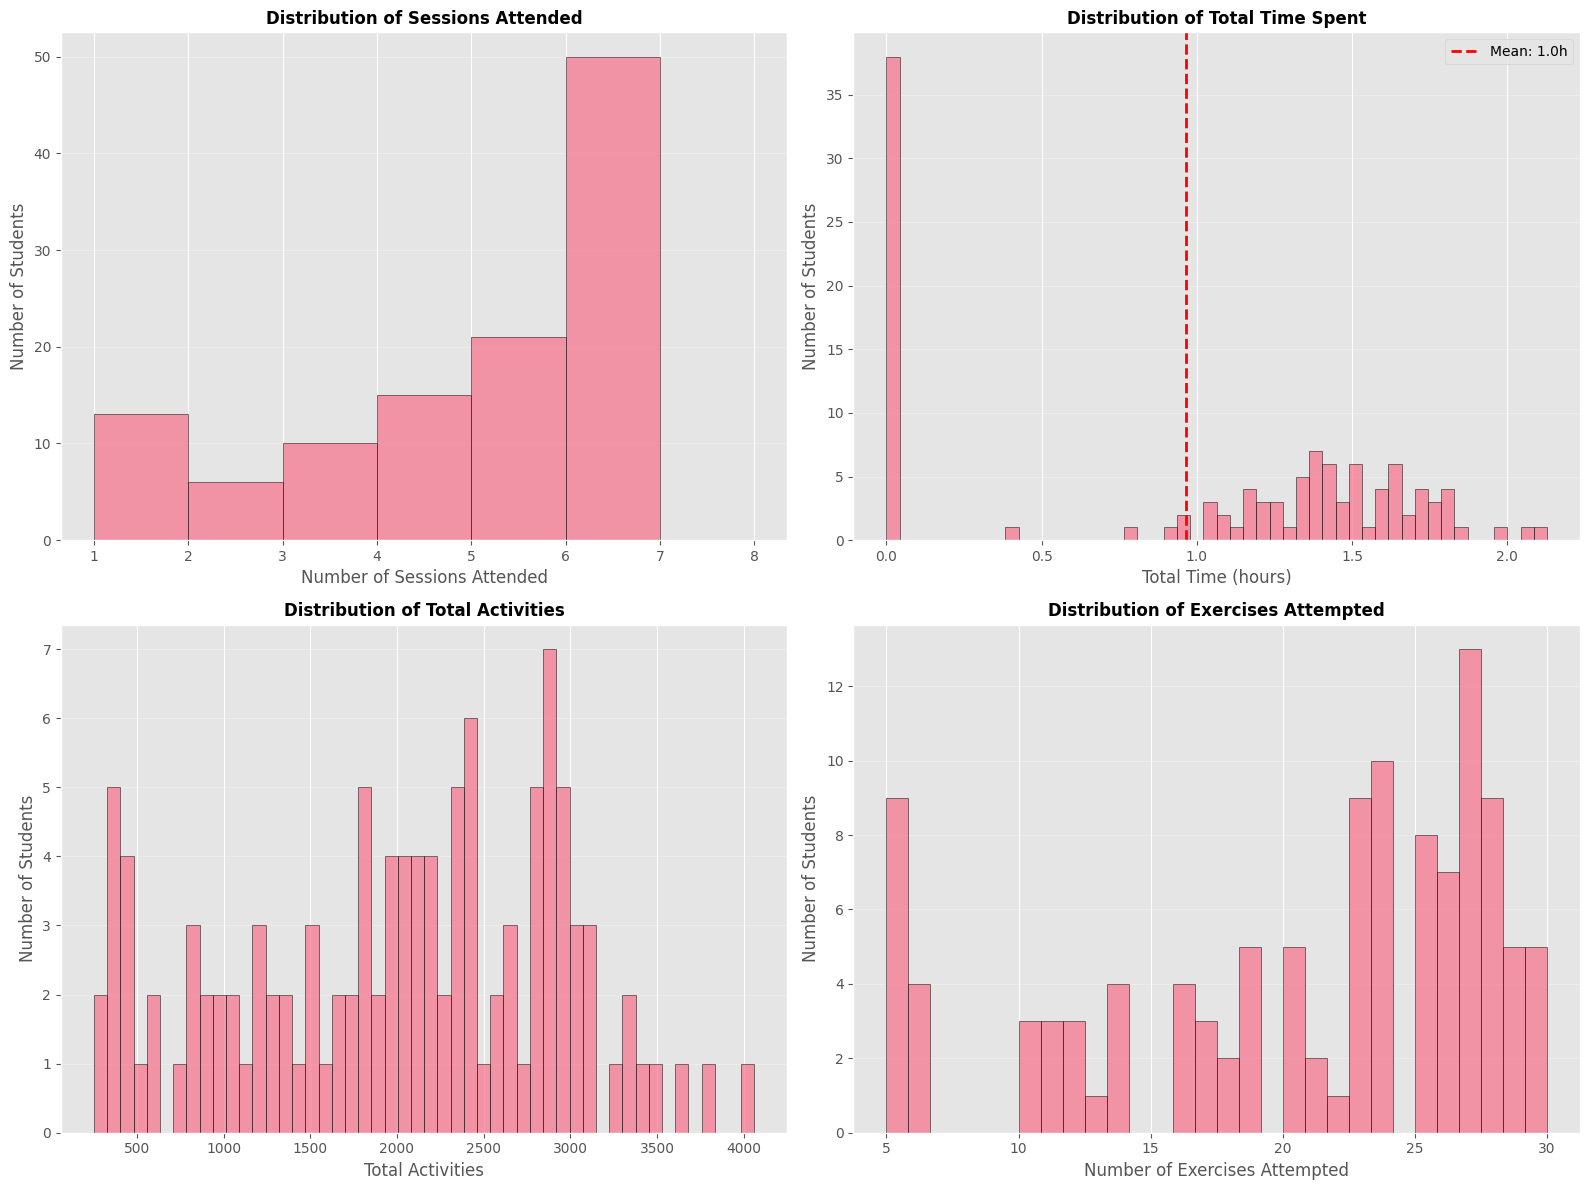

In [25]:
# Visualize student engagement metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sessions attended distribution
axes[0, 0].hist(student_stats['sessions_attended'], bins=range(1, 9), edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Sessions Attended', fontsize=12)
axes[0, 0].set_ylabel('Number of Students', fontsize=12)
axes[0, 0].set_title('Distribution of Sessions Attended', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Total time distribution
axes[0, 1].hist(student_stats['total_time_hours'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(student_stats['total_time_hours'].mean(), 
                   color='red', linestyle='--', linewidth=2, label=f'Mean: {student_stats["total_time_hours"].mean():.1f}h')
axes[0, 1].set_xlabel('Total Time (hours)', fontsize=12)
axes[0, 1].set_ylabel('Number of Students', fontsize=12)
axes[0, 1].set_title('Distribution of Total Time Spent', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Total activities
axes[1, 0].hist(student_stats['total_activities'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Total Activities', fontsize=12)
axes[1, 0].set_ylabel('Number of Students', fontsize=12)
axes[1, 0].set_title('Distribution of Total Activities', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Exercises attempted
axes[1, 1].hist(student_stats['exercises_attempted'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Number of Exercises Attempted', fontsize=12)
axes[1, 1].set_ylabel('Number of Students', fontsize=12)
axes[1, 1].set_title('Distribution of Exercises Attempted', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [26]:
# Student engagement score
student_stats['engagement_score'] = (
    student_stats['total_activities'] / 1000 +
    student_stats['total_time_hours'] / 10 +
    student_stats['total_clicks'] / 1000 +
    student_stats['total_keystrokes'] / 500
)

# Top and bottom engaged students
print("Top 10 Most Engaged Students:")
print("=" * 60)
top_engaged = student_stats.nlargest(10, 'engagement_score')[['student_Id', 'sessions_attended', 
                                                                 'total_time_hours', 'total_activities', 
                                                                 'engagement_score']]
print(top_engaged)

print("\nBottom 10 Least Engaged Students:")
print("=" * 60)
bottom_engaged = student_stats.nsmallest(10, 'engagement_score')[['student_Id', 'sessions_attended', 
                                                                   'total_time_hours', 'total_activities', 
                                                                   'engagement_score']]
print(bottom_engaged)


Top 10 Most Engaged Students:
    student_Id  sessions_attended  total_time_hours  total_activities  \
65          66                  6          0.966944              3033   
43          44                  6          1.056944              3377   
31          32                  6          1.461111              3628   
85          86                  6          1.233056              3108   
3            4                  6          1.351944              3761   
75          76                  6          1.395000              3106   
38          39                  6          1.596944              3103   
48          49                  6          1.427222              3291   
40          41                  5          0.000000              2378   
4            5                  6          1.383333              2956   

    engagement_score  
65        117.920694  
43         89.015694  
31         77.537111  
85         74.462306  
3          71.738194  
75         70.518500  
38   

## 8. Grades Analysis


In [27]:
# Load grades data
final_grades_path = os.path.join(dataset_dir, 'Data', 'final_grades.xlsx')
intermediate_grades_path = os.path.join(dataset_dir, 'Data', 'intermediate_grades.xlsx')

# Load final grades (2 sheets)
final_grades_sheet1 = pd.read_excel(final_grades_path, sheet_name=0)
final_grades_sheet2 = pd.read_excel(final_grades_path, sheet_name=1)

print("Final Grades Sheet 1:")
print("=" * 60)
print(f"Shape: {final_grades_sheet1.shape}")
print(f"Columns: {list(final_grades_sheet1.columns)}")
print(final_grades_sheet1.head())

print("\nFinal Grades Sheet 2:")
print("=" * 60)
print(f"Shape: {final_grades_sheet2.shape}")
print(f"Columns: {list(final_grades_sheet2.columns)}")
print(final_grades_sheet2.head())


Final Grades Sheet 1:
Shape: (52, 18)
Columns: ['Student ID', 'ES 1.1 \n(2 points)', 'ES 1.2 \n(3 points)', 'ES 2.1\n(2 points)', 'ES 2.2\n(3 points)', 'ES 3.1\n(1 points)', 'ES 3.2\n(2 points)', 'ES 3.3\n(2 points)', 'ES 3.4\n(2 points)', 'ES 3.5\n(3 points)', 'ES 4.1\n(15 points)', 'ES 4.2\n(10 points)', 'ES 5.1\n(2 points)', 'ES 5.2\n(10 points)', 'ES 5.3\n(3 points)', 'ES 6.1\n(25 points)', 'ES 6.2\n(15 points)', 'TOTAL\n(100 points)']
   Student ID  ES 1.1 \n(2 points)  ES 1.2 \n(3 points)  ES 2.1\n(2 points)  \
0           3                  2.0                    3                 1.0   
1           6                  2.0                    3                 2.0   
2           7                  2.0                    3                 1.0   
3          10                  2.0                    3                 2.0   
4          13                  2.0                    3                 2.0   

   ES 2.2\n(3 points)  ES 3.1\n(1 points)  ES 3.2\n(2 points)  \
0               

In [28]:
# Load intermediate grades
intermediate_grades = pd.read_excel(intermediate_grades_path)

print("Intermediate Grades:")
print("=" * 60)
print(f"Shape: {intermediate_grades.shape}")
print(f"Columns: {list(intermediate_grades.columns)}")
print(intermediate_grades.head())

# Check for student ID column (might be named differently)
print("\nColumn names in intermediate grades:")
for col in intermediate_grades.columns:
    print(f"  {col}: {intermediate_grades[col].dtype}")


Intermediate Grades:
Shape: (115, 6)
Columns: ['Student Id', 'Session 2', 'Session 3', 'Session 4', 'Session 5', 'Session 6']
   Student Id  Session 2  Session 3  Session 4  Session 5  Session 6
0           1        5.0        0.0        4.5        4.0       2.25
1           2        4.0        3.5        4.5        4.0       1.00
2           3        3.5        3.5        4.5        4.0       0.00
3           4        6.0        4.0        5.0        3.5       2.75
4           5        5.0        4.0        5.0        4.0       2.75

Column names in intermediate grades:
  Student Id: int64
  Session 2: float64
  Session 3: float64
  Session 4: float64
  Session 5: float64
  Session 6: float64


In [29]:
# Try to identify student ID column and analyze grades
# Common column names for student ID
id_columns = ['Student Id', 'student_Id', 'student_id', 'Student_Id', 'ID', 'Id', 'id']

def find_id_column(df):
    for col in id_columns:
        if col in df.columns:
            return col
    # If not found, try first column
    return df.columns[0]

# Analyze final grades
final_id_col1 = find_id_column(final_grades_sheet1)
final_id_col2 = find_id_column(final_grades_sheet2)

print(f"Final grades Sheet 1 - ID column: {final_id_col1}")
print(f"Final grades Sheet 2 - ID column: {final_id_col2}")

# Get numeric columns (grades)
numeric_cols1 = final_grades_sheet1.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols2 = final_grades_sheet2.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nNumeric columns in Sheet 1: {numeric_cols1}")
print(f"Numeric columns in Sheet 2: {numeric_cols2}")

# Summary statistics for final grades
if numeric_cols1:
    print("\nFinal Grades Sheet 1 - Summary:")
    print(final_grades_sheet1[numeric_cols1].describe())


Final grades Sheet 1 - ID column: Student ID
Final grades Sheet 2 - ID column: Student ID

Numeric columns in Sheet 1: ['Student ID', 'ES 1.1 \n(2 points)', 'ES 1.2 \n(3 points)', 'ES 2.1\n(2 points)', 'ES 2.2\n(3 points)', 'ES 3.1\n(1 points)', 'ES 3.2\n(2 points)', 'ES 3.3\n(2 points)', 'ES 3.4\n(2 points)', 'ES 3.5\n(3 points)', 'ES 4.1\n(15 points)', 'ES 4.2\n(10 points)', 'ES 5.1\n(2 points)', 'ES 5.2\n(10 points)', 'ES 5.3\n(3 points)', 'ES 6.1\n(25 points)', 'ES 6.2\n(15 points)', 'TOTAL\n(100 points)']
Numeric columns in Sheet 2: ['Student ID', 'ES 1.1 \n(2 points)', 'ES 1.2 \n(3 points)', 'ES 2.1\n(2 points)', 'ES 2.2\n(3 points)', 'ES 3.1\n(1 points)', 'ES 3.2\n(2 points)', 'ES 3.3\n(2 points)', 'ES 3.4\n(2 points)', 'ES 3.5\n(3 points)', 'ES 4.1\n(15 points)', 'ES 4.2\n(10 points)', 'ES 5.1\n(2 points)', 'ES 5.2\n(10 points)', 'ES 5.3\n(3 points)', 'ES 6.1\n(25 points)', 'ES 6.2\n(15 points)', 'TOTAL\n(100 points)']

Final Grades Sheet 1 - Summary:
       Student ID  ES 1.1 

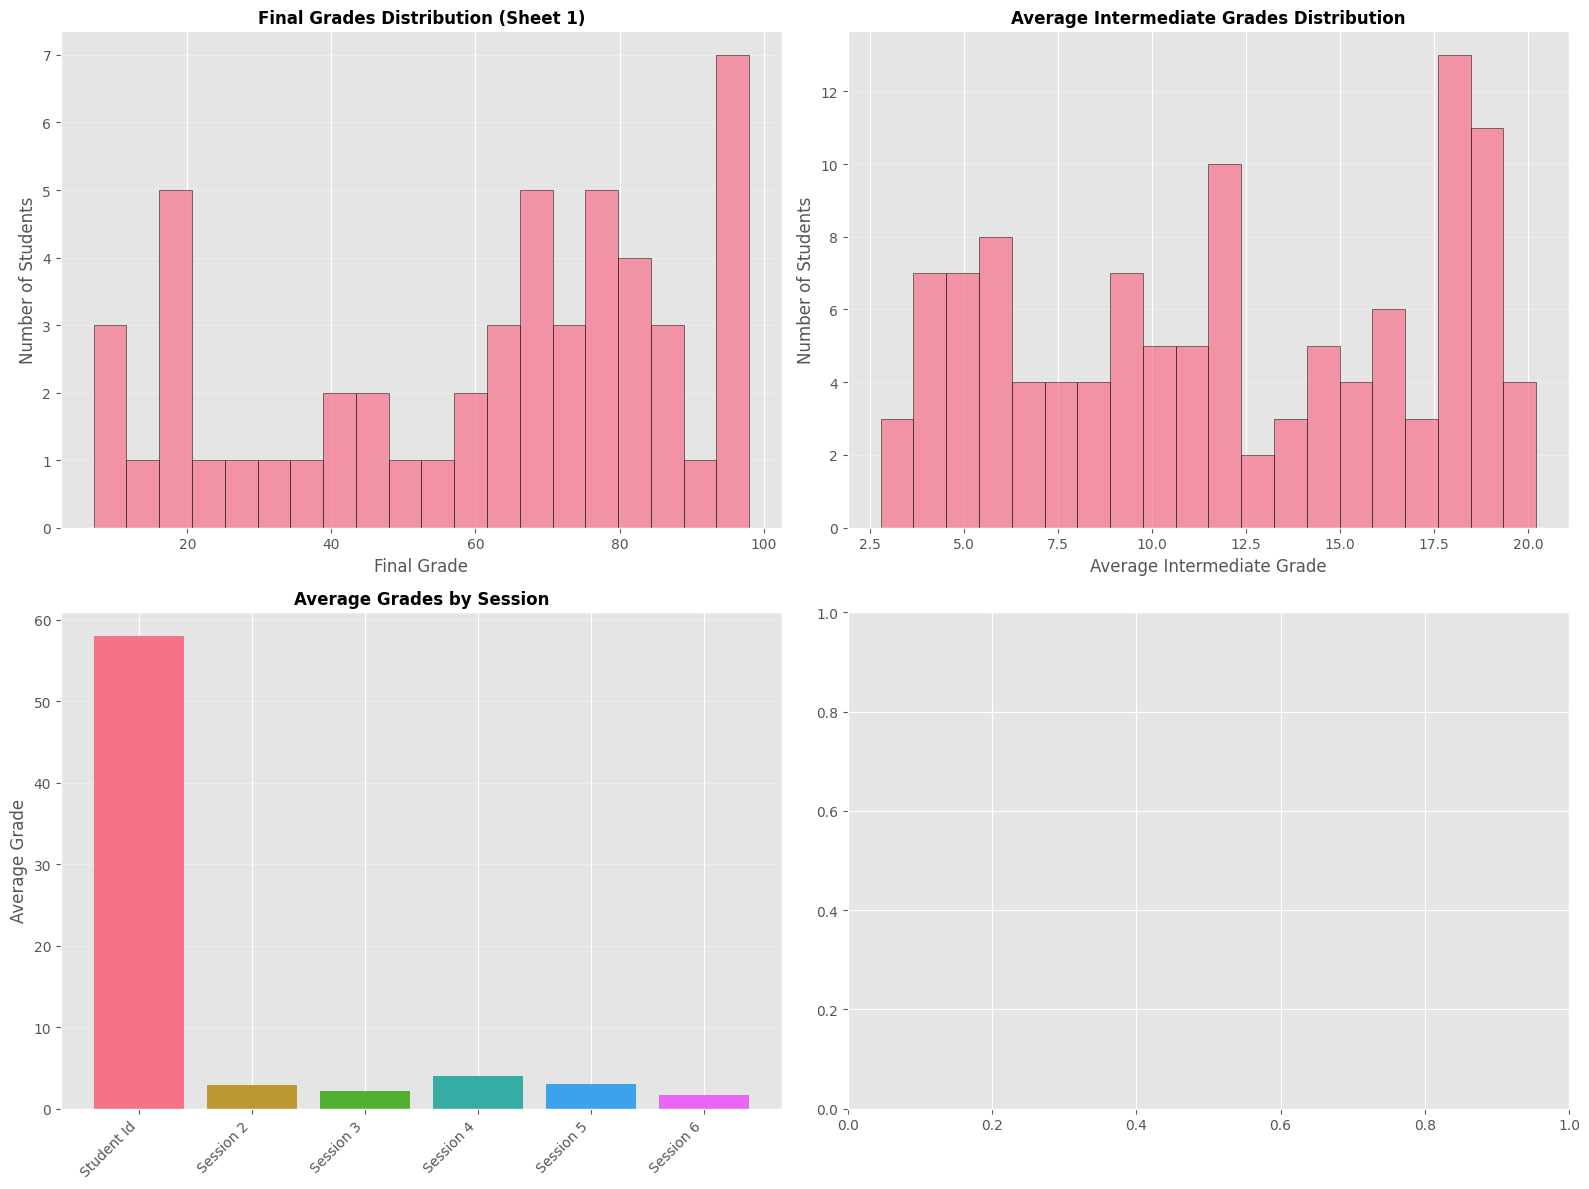

In [30]:
# Visualize grades distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Final grades distribution (if total grade column exists)
total_grade_cols = [col for col in final_grades_sheet1.columns if 'total' in str(col).lower() or 'final' in str(col).lower() or 'grade' in str(col).lower()]
if not total_grade_cols:
    # Try to find the last numeric column (often the total)
    total_grade_cols = [numeric_cols1[-1]] if numeric_cols1 else []

if total_grade_cols:
    axes[0, 0].hist(final_grades_sheet1[total_grade_cols[0]].dropna(), bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Final Grade', fontsize=12)
    axes[0, 0].set_ylabel('Number of Students', fontsize=12)
    axes[0, 0].set_title('Final Grades Distribution (Sheet 1)', fontsize=12, fontweight='bold')
    axes[0, 0].grid(axis='y', alpha=0.3)

# Intermediate grades analysis
intermediate_id_col = find_id_column(intermediate_grades)
intermediate_numeric = intermediate_grades.select_dtypes(include=[np.number]).columns.tolist()

if intermediate_numeric:
    # Average intermediate grade per student
    if intermediate_id_col in intermediate_grades.columns:
        student_avg_grades = intermediate_grades.groupby(intermediate_id_col)[intermediate_numeric].mean().mean(axis=1)
        axes[0, 1].hist(student_avg_grades.dropna(), bins=20, edgecolor='black', alpha=0.7)
        axes[0, 1].set_xlabel('Average Intermediate Grade', fontsize=12)
        axes[0, 1].set_ylabel('Number of Students', fontsize=12)
        axes[0, 1].set_title('Average Intermediate Grades Distribution', fontsize=12, fontweight='bold')
        axes[0, 1].grid(axis='y', alpha=0.3)

# Session-wise intermediate grades (if session columns exist)
session_cols = [col for col in intermediate_grades.columns if 'session' in str(col).lower() or 's' in str(col).lower()]
if session_cols:
    session_means = intermediate_grades[session_cols].mean()
    axes[1, 0].bar(range(len(session_means)), session_means.values, color=sns.color_palette("husl", len(session_means)))
    axes[1, 0].set_xticks(range(len(session_means)))
    axes[1, 0].set_xticklabels(session_means.index, rotation=45, ha='right')
    axes[1, 0].set_ylabel('Average Grade', fontsize=12)
    axes[1, 0].set_title('Average Grades by Session', fontsize=12, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Correlation Analysis: Behavior vs. Performance


In [31]:
# Merge student stats with grades (if possible)
# This is a simplified version - actual merging depends on grade file structure

# Create a summary of student engagement metrics
engagement_summary = student_stats[['student_Id', 'sessions_attended', 'total_time_hours', 
                                    'total_activities', 'total_clicks', 'total_keystrokes', 
                                    'engagement_score']].copy()

print("Student Engagement Summary (sample):")
print("=" * 60)
print(engagement_summary.head(10))

# Calculate correlations between engagement metrics
correlation_matrix = engagement_summary.select_dtypes(include=[np.number]).corr()
print("\nCorrelation Matrix of Engagement Metrics:")
print("=" * 60)
print(correlation_matrix)


Student Engagement Summary (sample):
   student_Id  sessions_attended  total_time_hours  total_activities  \
0           1                  5          1.826111              2826   
1           2                  6          1.239444              1852   
2           3                  4          0.000000              2265   
3           4                  6          1.351944              3761   
4           5                  6          1.383333              2956   
5           6                  5          0.000000              2941   
6           7                  6          1.487500              2027   
7           8                  4          0.000000              1239   
8           9                  5          0.895000              2222   
9          10                  6          1.432500              3330   

   total_clicks  total_keystrokes  engagement_score  
0         20274             12920         49.122611  
1         17254             18268         55.765944  
2       

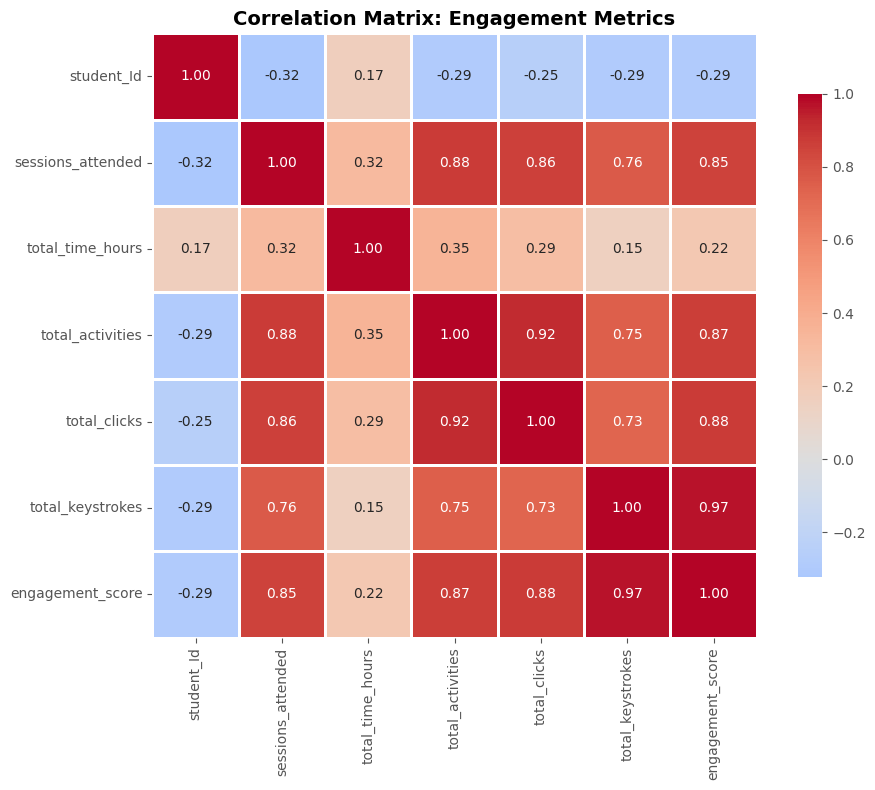

In [32]:
# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Engagement Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [33]:
# Activity category usage by student
activity_usage = df.groupby(['student_Id', 'activity_category']).size().unstack(fill_value=0)
activity_usage_pct = activity_usage.div(activity_usage.sum(axis=1), axis=0) * 100

print("Activity Category Usage by Student (Top 10 students by total activities):")
print("=" * 60)
top_students = student_stats.nlargest(10, 'total_activities')['student_Id'].tolist()
print(activity_usage_pct.loc[top_students])


Activity Category Usage by Student (Top 10 students by total activities):
activity_category  Deeds_Simulator  FSM_Simulator      Other      Study  \
student_Id                                                                
74                       20.684560       7.239596  48.608717   8.593942   
4                        13.932465      10.342994  52.140388   8.508375   
32                       16.317530      11.466373  45.837927  10.859978   
20                       15.108538       7.120116  53.921852   7.062229   
44                       16.316257       7.195736  46.431744  13.888066   
10                       18.618619       8.138138  46.636637   6.456456   
82                       18.247734       8.489426  46.132931   9.788520   
49                       13.855971       9.753874  49.802492   9.541173   
86                       16.377091      11.808237  45.012870   9.942085   
76                       15.421764       8.660657  50.772698   9.336768   

activity_category  TextEd

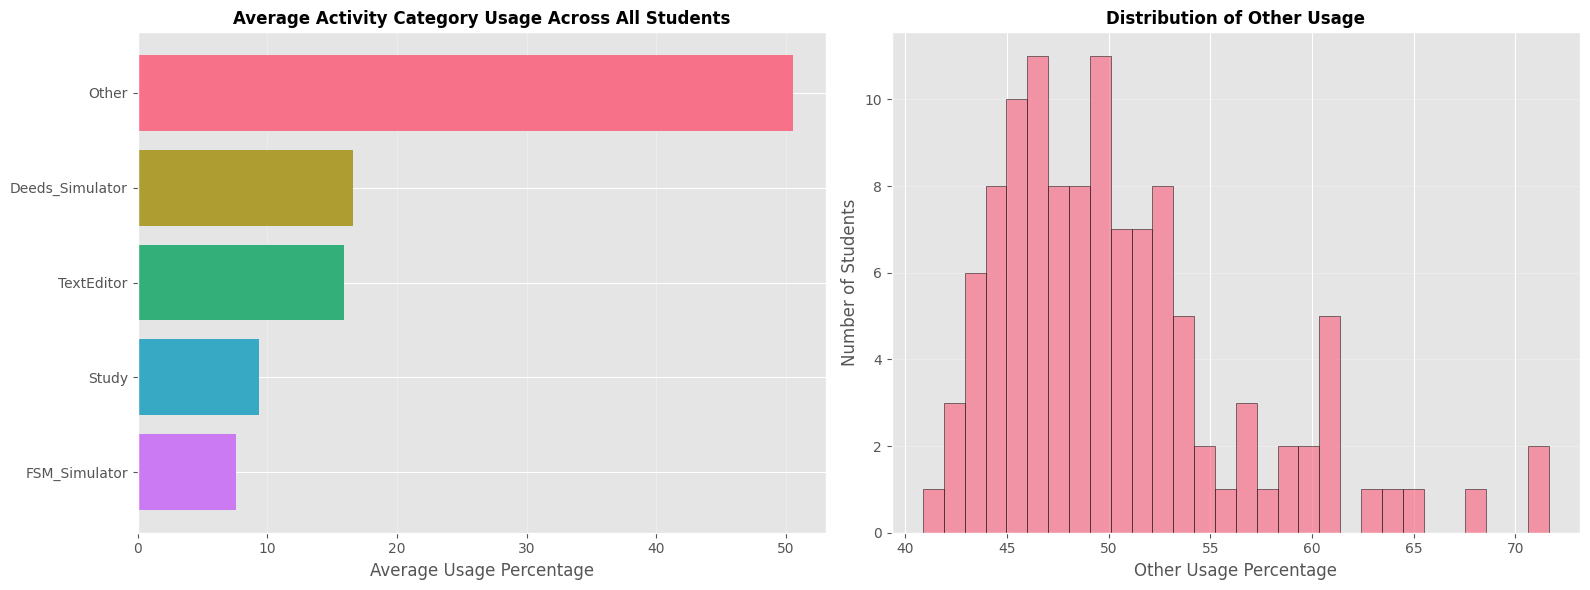

In [34]:
# Visualize activity category usage
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Average usage by category
avg_usage = activity_usage_pct.mean().sort_values(ascending=False)
axes[0].barh(range(len(avg_usage)), avg_usage.values, color=sns.color_palette("husl", len(avg_usage)))
axes[0].set_yticks(range(len(avg_usage)))
axes[0].set_yticklabels(avg_usage.index)
axes[0].set_xlabel('Average Usage Percentage', fontsize=12)
axes[0].set_title('Average Activity Category Usage Across All Students', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Usage distribution for top category
top_category = avg_usage.index[0]
axes[1].hist(activity_usage_pct[top_category], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel(f'{top_category} Usage Percentage', fontsize=12)
axes[1].set_ylabel('Number of Students', fontsize=12)
axes[1].set_title(f'Distribution of {top_category} Usage', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Session Comparison


In [35]:
# Compare sessions
session_comparison = df.groupby('session').agg({
    'student_Id': 'nunique',
    'exercise': 'nunique',
    'activity': 'count',
    'duration_minutes': 'sum',
    'idle_time_seconds': 'sum',
    'mouse_movement': 'sum',
    'keystroke': 'sum'
}).reset_index()

session_comparison.columns = ['session', 'unique_students', 'unique_exercises', 'total_activities',
                              'total_time_minutes', 'total_idle_seconds', 'total_mouse_movement', 'total_keystrokes']
session_comparison['total_time_hours'] = session_comparison['total_time_minutes'] / 60
session_comparison['avg_time_per_student'] = session_comparison['total_time_hours'] / session_comparison['unique_students']

print("Session Comparison:")
print("=" * 60)
print(session_comparison)


Session Comparison:
   session  unique_students  unique_exercises  total_activities  \
0        1               77                 5             34294   
1        2               82                10             39549   
2        3               87                15             29127   
3        4               99                11             39709   
4        5               91                12             34469   
5        6               84                12             53170   

   total_time_minutes  total_idle_seconds  total_mouse_movement  \
0              6654.3        9.021782e+06              11418729   
1                 0.0        4.438960e+07              15995841   
2                 0.0        1.243190e+08              18495006   
3                 0.0        2.220303e+07              11961516   
4                 0.0       -4.258348e+11              13361619   
5                 0.0        3.442759e+07              24241644   

   total_keystrokes  total_time_hours  a

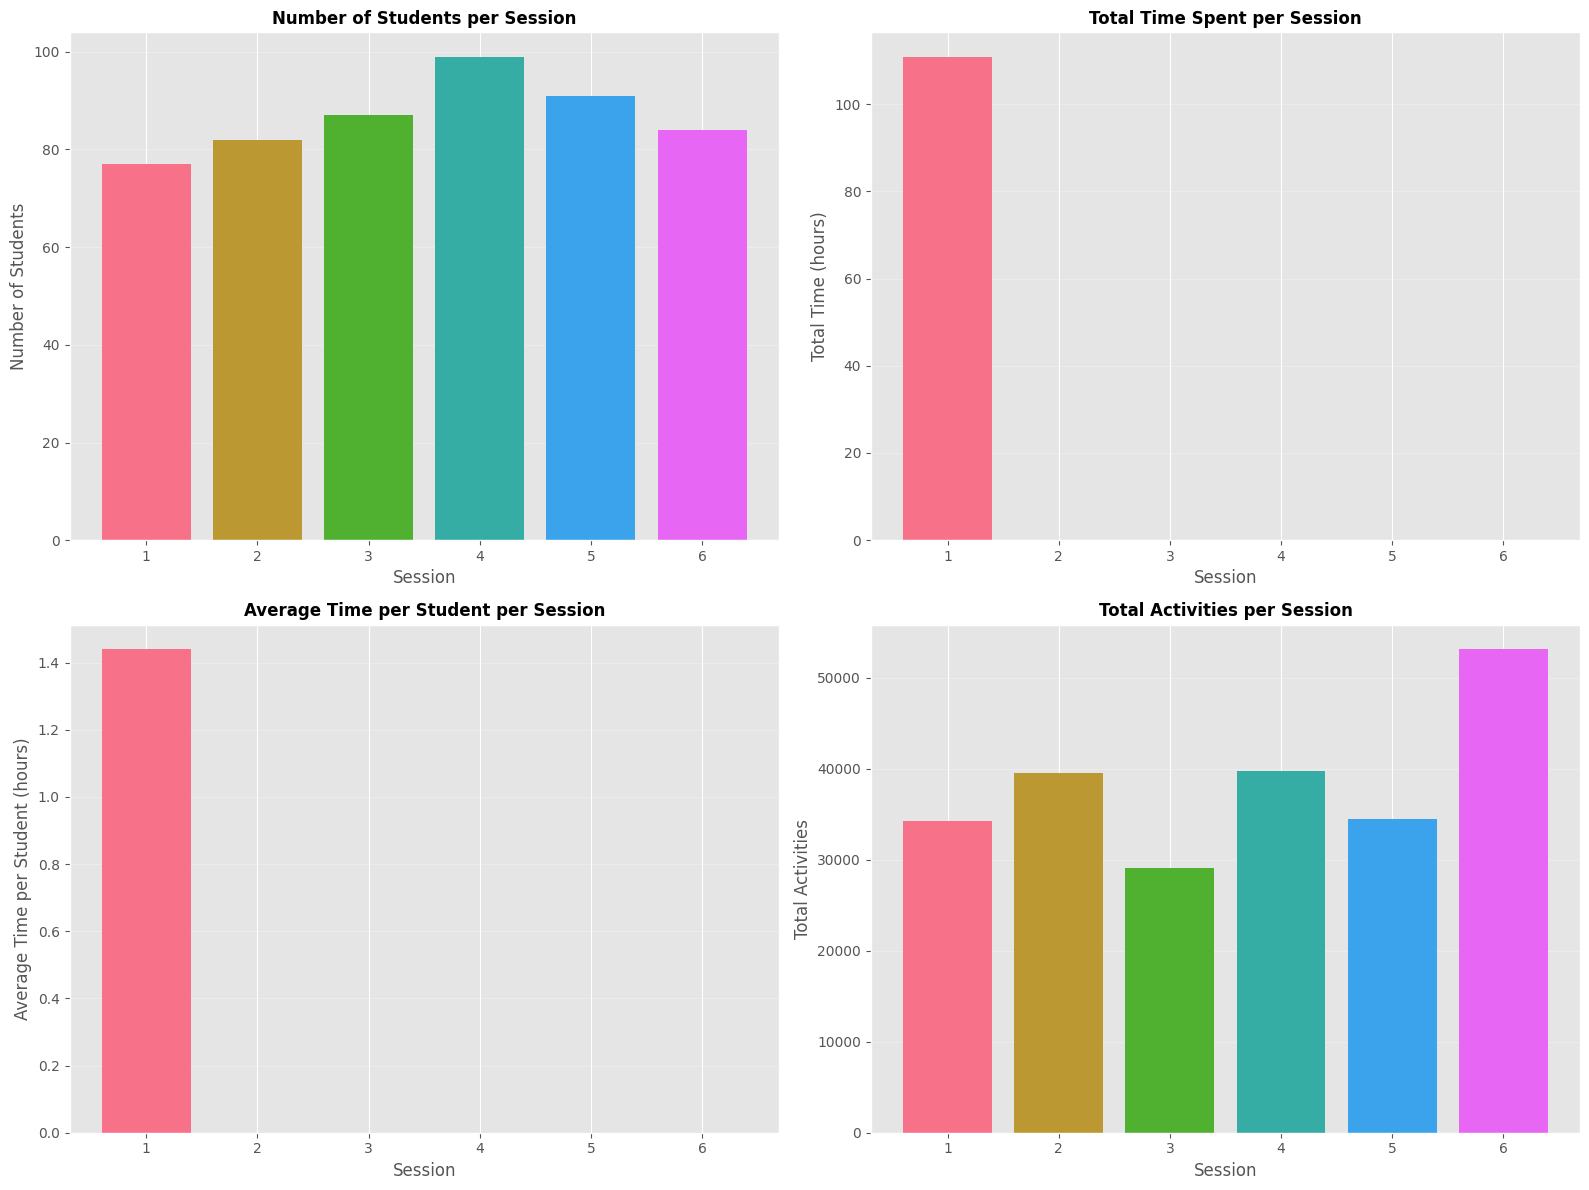

In [36]:
# Visualize session comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Students per session
axes[0, 0].bar(session_comparison['session'], session_comparison['unique_students'], 
               color=sns.color_palette("husl", len(session_comparison)))
axes[0, 0].set_xlabel('Session', fontsize=12)
axes[0, 0].set_ylabel('Number of Students', fontsize=12)
axes[0, 0].set_title('Number of Students per Session', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Total time per session
axes[0, 1].bar(session_comparison['session'], session_comparison['total_time_hours'], 
               color=sns.color_palette("husl", len(session_comparison)))
axes[0, 1].set_xlabel('Session', fontsize=12)
axes[0, 1].set_ylabel('Total Time (hours)', fontsize=12)
axes[0, 1].set_title('Total Time Spent per Session', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Average time per student
axes[1, 0].bar(session_comparison['session'], session_comparison['avg_time_per_student'], 
               color=sns.color_palette("husl", len(session_comparison)))
axes[1, 0].set_xlabel('Session', fontsize=12)
axes[1, 0].set_ylabel('Average Time per Student (hours)', fontsize=12)
axes[1, 0].set_title('Average Time per Student per Session', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Total activities
axes[1, 1].bar(session_comparison['session'], session_comparison['total_activities'], 
               color=sns.color_palette("husl", len(session_comparison)))
axes[1, 1].set_xlabel('Session', fontsize=12)
axes[1, 1].set_ylabel('Total Activities', fontsize=12)
axes[1, 1].set_title('Total Activities per Session', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Activity Category Distribution by Session (%):
activity_category  Deeds_Simulator  FSM_Simulator  Other  Study  TextEditor
session                                                                    
1                            21.00           0.00  54.21  10.87       13.92
2                            21.83           0.00  45.54  10.65       21.99
3                            20.60           0.00  45.33   8.24       25.83
4                            16.23           0.00  62.98   7.01       13.78
5                            21.11           0.00  45.24  12.36       21.29
6                             3.29          38.69  42.46   8.39        7.17


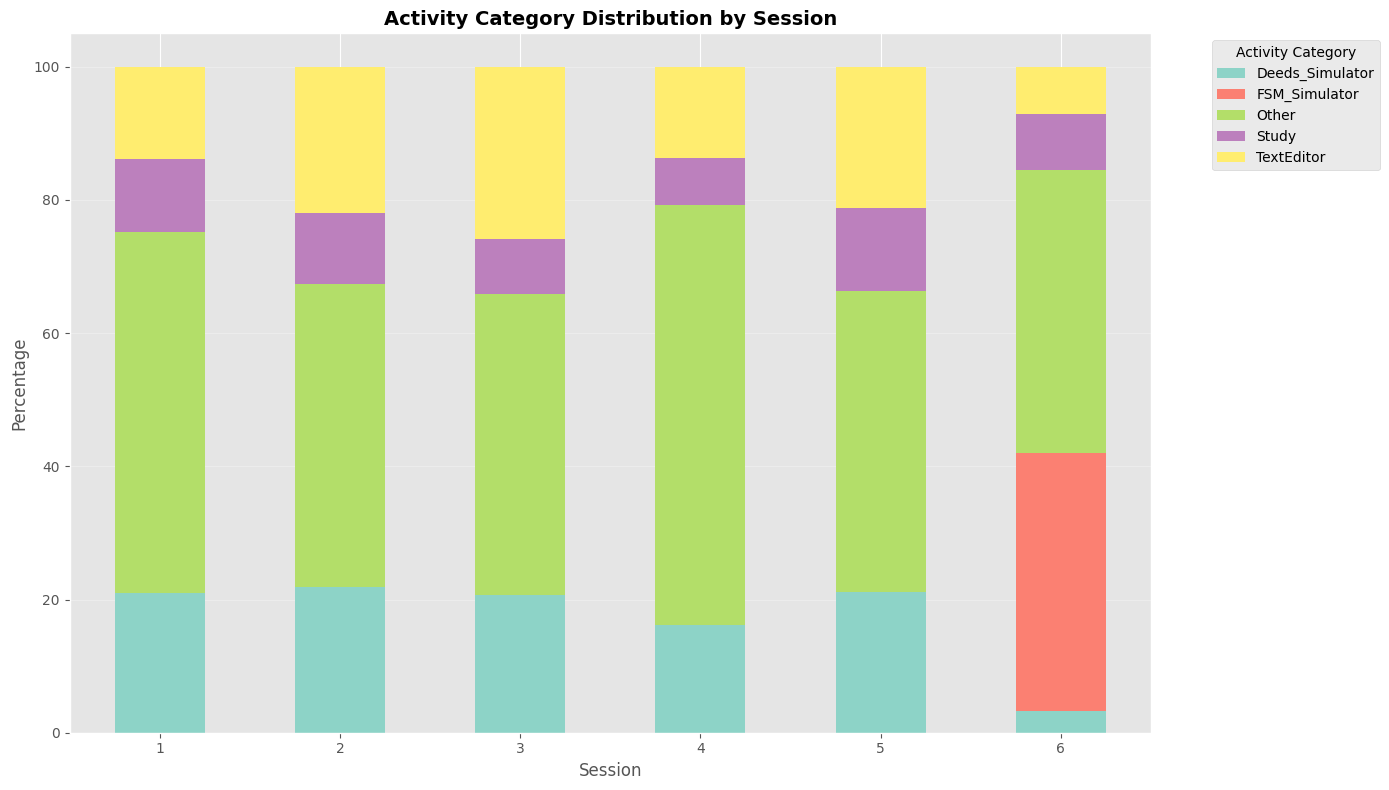

In [37]:
# Activity category distribution by session
activity_by_session = df.groupby(['session', 'activity_category']).size().unstack(fill_value=0)
activity_by_session_pct = activity_by_session.div(activity_by_session.sum(axis=1), axis=0) * 100

print("Activity Category Distribution by Session (%):")
print("=" * 60)
print(activity_by_session_pct.round(2))

# Visualize
fig, ax = plt.subplots(figsize=(14, 8))
activity_by_session_pct.plot(kind='bar', stacked=True, ax=ax, colormap='Set3')
ax.set_xlabel('Session', fontsize=12)
ax.set_ylabel('Percentage', fontsize=12)
ax.set_title('Activity Category Distribution by Session', fontsize=14, fontweight='bold')
ax.legend(title='Activity Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## 11. Key Findings and Summary


In [38]:
# Summary of key findings
print("=" * 60)
print("KEY FINDINGS SUMMARY")
print("=" * 60)

print(f"\n1. DATASET SCALE:")
print(f"   - Total records: {len(df):,}")
print(f"   - Unique students: {df['student_Id'].nunique()}")
print(f"   - Sessions: {sorted(df['session'].unique())}")
print(f"   - Date range: {df['start_time'].min().date()} to {df['start_time'].max().date()}")

print(f"\n2. ACTIVITY PATTERNS:")
print(f"   - Most common activity: {activity_counts.index[0]} ({activity_counts.iloc[0]:,} occurrences)")
print(f"   - Most common category: {category_counts.index[0]} ({category_counts.iloc[0]:,} occurrences)")
print(f"   - Unique activities: {df['activity'].nunique()}")

print(f"\n3. TEMPORAL PATTERNS:")
print(f"   - Average session duration: {session_durations['session_duration_hours'].mean():.2f} hours")
print(f"   - Average activity duration: {activity_durations['duration_minutes'].mean():.2f} minutes")
print(f"   - Peak activity hour: {hourly_activity.idxmax()}:00")

print(f"\n4. STUDENT ENGAGEMENT:")
print(f"   - Average sessions attended: {student_stats['sessions_attended'].mean():.2f}")
print(f"   - Average total time: {student_stats['total_time_hours'].mean():.2f} hours")
print(f"   - Average activities per student: {student_stats['total_activities'].mean():.0f}")

print(f"\n5. INTERACTION METRICS:")
print(f"   - Total mouse movements: {df['mouse_movement'].sum():,}")
print(f"   - Total clicks: {df['mouse_click_left'].sum() + df['mouse_click_right'].sum():,}")
print(f"   - Total keystrokes: {df['keystroke'].sum():,}")

print(f"\n6. EXERCISES:")
print(f"   - Total unique exercises: {df['exercise'].nunique()}")
print(f"   - Exercises per session: {dict(exercises_per_session)}")

print("\n" + "=" * 60)


KEY FINDINGS SUMMARY

1. DATASET SCALE:
   - Total records: 230,318
   - Unique students: 115
   - Sessions: [1, 2, 3, 4, 5, 6]
   - Date range: 2014-10-02 to 2014-10-02

2. ACTIVITY PATTERNS:
   - Most common activity:  Other (33,602 occurrences)
   - Most common category: Other (112,983 occurrences)
   - Unique activities: 99

3. TEMPORAL PATTERNS:
   - Average session duration: 1.59 hours
   - Average activity duration: 0.26 minutes
   - Peak activity hour: 12.0:00

4. STUDENT ENGAGEMENT:
   - Average sessions attended: 4.52
   - Average total time: 0.96 hours
   - Average activities per student: 2003

5. INTERACTION METRICS:
   - Total mouse movements: 95,474,355
   - Total clicks: 1,705,478
   - Total keystrokes: 1,446,359

6. EXERCISES:
   - Total unique exercises: 30
   - Exercises per session: {1: 5, 2: 10, 3: 15, 4: 11, 5: 12, 6: 12}

